# Predicting Logerror
### By Jessica Gardin
### 8-9-2022

In [1]:
# personally made imports
import env
import acquire_to_py

# typical imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Modeling
from sklearn.model_selection import train_test_split
# model evaluation
from sklearn.metrics import mean_squared_error
# clustering
from sklearn.cluster import KMeans, DBSCAN
# linear regression             #line             #supreses size of coeficients-get rid of tiny coefficients to reduce noise/overfitting # tweedie like glm 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
# classification models-beware, you have continuous target variable
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

# Preferences
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

acquire_to_py.new_zillow_data()
acquire_to_py.get_zillow_data()
acquire_to_py.handle_missing_values(df, fraction_required_cols, fraction_required_rows)
acquire_to_py.remaining_nulls(df)
acquire_to_py.prep_zillow(df, prop_req_cols, prop_req_rows)


In [2]:
df = acquire_to_py.get_zillow_data()

In [3]:
df.head()

parcelid  logerror transactiondate  bath  bed    sqft    fips    latitude  \
0  14297519  0.025595      2017-01-01   3.5  4.0  3100.0  6059.0  33634931.0   
1  17052889  0.055619      2017-01-01   1.0  2.0  1465.0  6111.0  34449266.0   
2  14186244  0.005383      2017-01-01   2.0  3.0  1243.0  6059.0  33886168.0   
3  12177905 -0.103410      2017-01-01   3.0  4.0  2376.0  6037.0  34245180.0   
4  12095076 -0.001011      2017-01-01   3.0  4.0  2962.0  6037.0  34145202.0   

     longitude  lot_sqft propertycountylandusecode  rawcensustractandblock  \
0 -117869207.0    4506.0                       122            6.059063e+07   
1 -119281531.0   12647.0                      1110            6.111001e+07   
2 -117823170.0    8432.0                       122            6.059022e+07   
3 -118240722.0   13038.0                      0101            6.037300e+07   
4 -118179824.0   63000.0                      0101            6.037461e+07   

   regionidcity  regionidcounty      zip  yearbuilt  censustractandblock  
0       53571.0          1286.0  96978.0     1998.0         6.059063e+13  
1       13091.0          2061.0  97099.0     1967.0         6.111001e+13  
2       21412.0          1286.0  97078.0     1962.0         6.059022e+13  
3      396551.0          3101.0  96330.0     1970.0         6.037300e+13  
4       47019.0          3101.0  96293.0     1950.0         6.037461e+13

In [4]:
df.shape

(51883, 17)

# NULLS

### SIZE
Lotsizesquarefeet -- median (skewed data set, use median not mean) \
Lotsizesquarefeet -- dropped 7 rows with suspect values (extremely large and identical, acquire_to_py.df_6971) \
Calculatedfinishedsquarefeet -- median (skewed dataset, use median not mean) \
Finishedsquarefeet12 -- dropped due to strong similarities to 'lotsizesquarefeet' column

### TIME
Assessmentyear -- 2016 for all values \
Year built -- mode (essentially catagorical in this case)

### TAX
Tax_columns -- dropped to mitigate target leakage

### COUNT
Fullbathcnt -- was missing values. Bed and bath are complete columns. I can make a more 	      accurately filled column using data available.

Calculatedbathnbr -- was missing values. Bed and bath are complete columns. I can make a more accurately filled column using data available. 

### LOCATION
Regionidcity -- mode (categorical) \
Regionidzip -- mode (categorical) \
Censustractandblock -- dropped 1 row based on suspect number (started with a 4 not a 6). Based on how census blocks are derived, I think it highly unlikely that the census block is accurate. also note, in the rawcensustractandblock, all values start with 6


### Columns
36 columns had > 30% nulls and were subsequently dropped \
List: acquire_to_py.col_drop_too_many_nulls

# Duplicates
121 rows were dropped for being duplicates by 'parcelid' \
List: acquire_to_py.duplicate_rows


# NULLS

### Columns
36 columns had > 30% nulls and were subsequently dropped 

List: acquire_to_py.col_drop_too_many_nulls

### TIME
Assessmentyear -- 2016 for all values

Year built -- mode (essentially catagorical in this case)

### TAX
Tax_columns -- dropped to mitigate target leakage

### SIZE
Lotsizesquarefeet -- median (skewed data set, use median not mean)

Lotsizesquarefeet -- dropped 7 rows with suspect values (extremely large and identical, acquire_to_py.df_6971)

Calculatedfinishedsquarefeet -- median (skewed dataset, use median not mean)

Finishedsquarefeet12 -- dropped due to strong similarities to 'lotsizesquarefeet' column

### COUNT
Fullbathcnt -- was missing values. Bed and bath are complete columns. I can make a more 	      accurately filled column using data available.

Calculatedbathnbr -- was missing values. Bed and bath are complete columns. I can make a more accurately filled column using data available. 

### LOCATION
Regionidcity -- mode (categorical)

Regionidzip -- mode (categorical)

Censustractandblock -- dropped 1 row based on suspect number (started with a 4 not a 6). Based on how census blocks are derived, I think it highly unlikely that the census block is accurate. also note, in the rawcensustractandblock, all values start with 6

# Duplicates
121 rows were dropped for being duplicates by 'parcelid' \
List: acquire_to_py.duplicate_rows

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51883 entries, 0 to 52440
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   parcelid                   51883 non-null  int64  
 1   logerror                   51883 non-null  float64
 2   transactiondate            51883 non-null  object 
 3   bath                       51883 non-null  float64
 4   bed                        51883 non-null  float64
 5   sqft                       51883 non-null  float64
 6   fips                       51883 non-null  float64
 7   latitude                   51883 non-null  float64
 8   longitude                  51883 non-null  float64
 9   lot_sqft                   51883 non-null  float64
 10  propertycountylandusecode  51883 non-null  object 
 11  rawcensustractandblock     51883 non-null  float64
 12  regionidcity               51883 non-null  float64
 13  regionidcounty             51883 non-null  flo

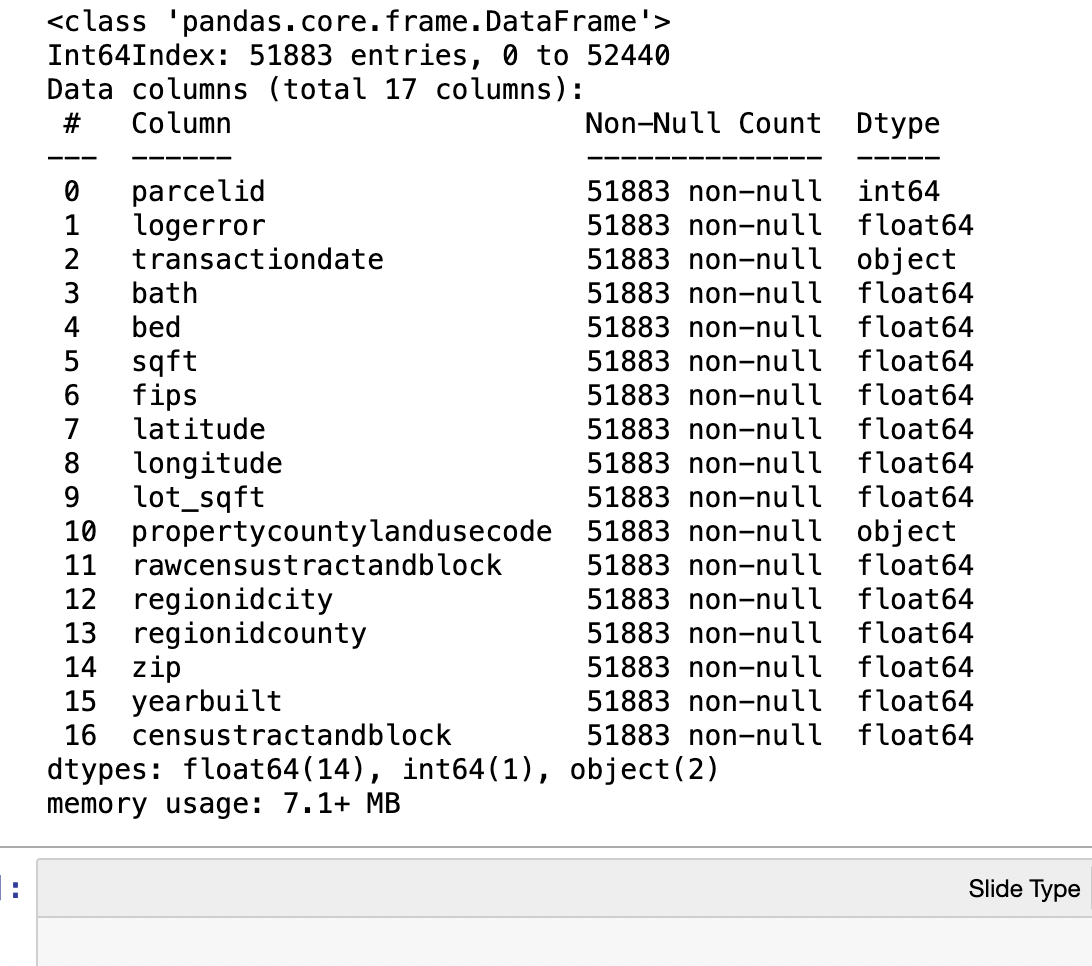

In [6]:
labels = pd.DataFrame({'prime_id': ['parcelid','','','','','',''], 
                       'targert_variable': ['logerror', '','','','','',''], 
                       'size': ['bath', 'bed', 'sqft', 'lot_sqft','','',''],
                       'time': ['yearbuilt', 'transactiondate', '','','','',''],
                       'location': ['zip', 'fips', 'latitude', 'longitude', 'regionidcity', 'regionidcounty', 'censustractandblock'],
                       'other': ['propertycountylandusecode', '', '', '', '', '', '']})

labels

prime_id targert_variable      size             time             location  \
0  parcelid         logerror      bath        yearbuilt                  zip   
1                                  bed  transactiondate                 fips   
2                                 sqft                              latitude   
3                             lot_sqft                             longitude   
4                                                               regionidcity   
5                                                             regionidcounty   
6                                                        censustractandblock   

                       other  
0  propertycountylandusecode  
1                             
2                             
3                             
4                             
5                             
6

log(actual price the home was sold)-log(predicted)

log(actual/predicted)

# Independent vs Dependent Variables

# Note:
l = df[['sqft', 'finishedsquarefeet12']] \
l['difference'] = l.sqft - l.finishedsquarefeet12 \
l.difference.value_counts()

was run in the prepare phase. It should've been run here. prepare file has already been updated accordingly.

Learned:
    Columns are almost identical, few differences. I don't know which column is most accurate. sqft column had the least nulls that I had to make up for so I will choose that one and drop the finishedsquarefeet12.

# 1 Location
How is does logerror change by location? ie. county? city? zip? censusdata? fips?

<AxesSubplot:xlabel='fips', ylabel='logerror'>

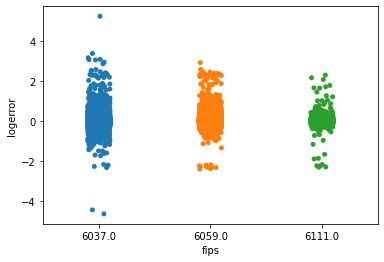

In [7]:
sns.stripplot(df.fips, df.logerror)

<AxesSubplot:xlabel='regionidcity', ylabel='logerror'>

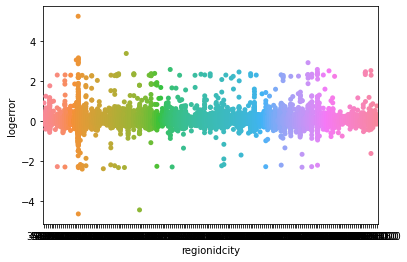

In [8]:
sns.stripplot(df.regionidcity, df.logerror)

<AxesSubplot:xlabel='regionidcounty', ylabel='logerror'>

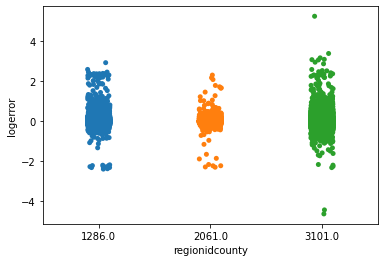

In [9]:
sns.stripplot(df.regionidcounty, df.logerror)

<AxesSubplot:xlabel='zip', ylabel='logerror'>

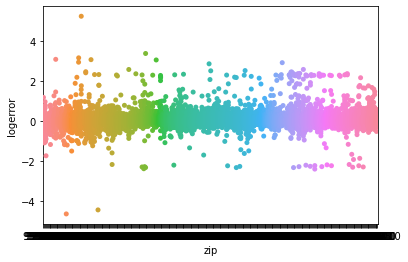

In [10]:
sns.stripplot(df.zip, df.logerror)


<AxesSubplot:xlabel='rawcensustractandblock', ylabel='logerror'>

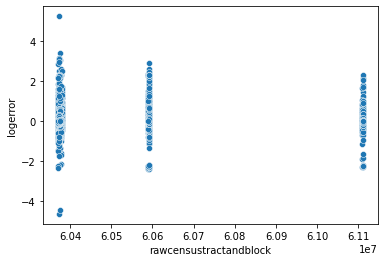

In [11]:
sns.scatterplot(df.rawcensustractandblock, df.logerror)

<AxesSubplot:xlabel='censustractandblock', ylabel='logerror'>

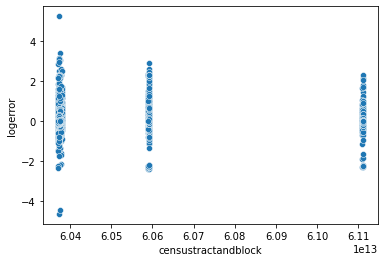

In [12]:
sns.scatterplot(df.censustractandblock, df.logerror)

In [13]:
# analyze

In [14]:
df.censustractandblock.sort_values()

20824    6.037101e+13
51442    6.037101e+13
18392    6.037101e+13
42243    6.037101e+13
28514    6.037101e+13
             ...     
21608    6.111009e+13
41920    6.111009e+13
24123    6.111009e+13
48649    6.111009e+13
42675    6.111009e+13
Name: censustractandblock, Length: 51883, dtype: float64

In [15]:
df[df.censustractandblock > 1e14]

Empty DataFrame
Columns: [parcelid, logerror, transactiondate, bath, bed, sqft, fips, latitude, longitude, lot_sqft, propertycountylandusecode, rawcensustractandblock, regionidcity, regionidcounty, zip, yearbuilt, censustractandblock]
Index: []

In [16]:
# based on how census blocks are derived, I think it highly unlikely that the census block above is accurate. 
# also notice above, it is not in the rawcensustractandblock
# i am dropping it.




In [17]:
df = df[df.censustractandblock < 1e14]

<AxesSubplot:xlabel='censustractandblock', ylabel='logerror'>

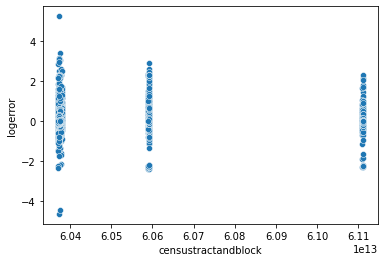

In [18]:
sns.scatterplot(df.censustractandblock, df.logerror)

In [19]:
# are there clusters within the groups?


In [20]:
df_low_cens = df[df.censustractandblock < 6.05e13]

<AxesSubplot:xlabel='censustractandblock', ylabel='logerror'>

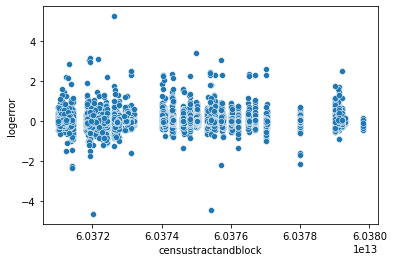

In [21]:
sns.scatterplot(df_low_cens.censustractandblock, df_low_cens.logerror)
# clusters, but not really away from zero

In [22]:
df_high_cens = df[df.censustractandblock > 6.105e13]

<AxesSubplot:xlabel='censustractandblock', ylabel='logerror'>

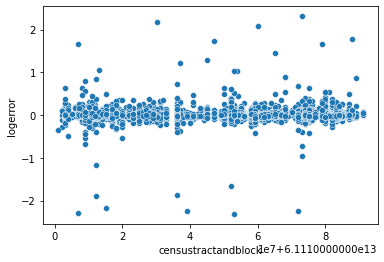

In [23]:
sns.scatterplot(df_high_cens.censustractandblock, df_high_cens.logerror)

# Takeaway
So far everything is an approximate horizonatal linear relationship

# 2 Time
How does logerror change with transaction date and year built?

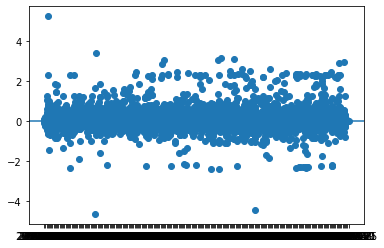

In [24]:
plt.scatter(df.transactiondate, df.logerror)

plt.axhline(y = 0)

<AxesSubplot:xlabel='yearbuilt', ylabel='logerror'>

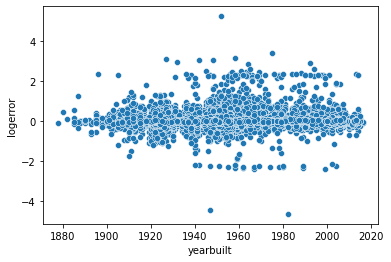

In [25]:
sns.scatterplot(df.yearbuilt, df.logerror)

# Takeaway

seems mostly unaffected by transaction date or year built

# 3 Size
How does logerror change with bed, bath, sqft, lot_sqft?

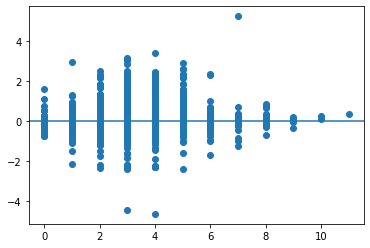

In [26]:
plt.scatter(df.bed, df.logerror)

plt.axhline(y = 0)

# Takeaway 

- seems fairly consistent regardelss of bedrooms
- most error in the 2-6 bathroom range, but that's also where the bulk of the data is  
- most data is still centered around zero in a horizontal line

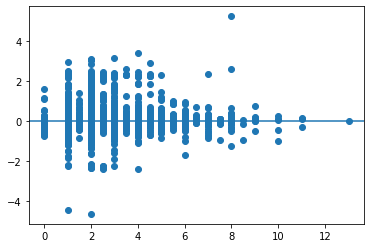

In [27]:
plt.scatter(df.bath, df.logerror)

plt.axhline(y = 0)

# Takeaway 

- possibly a slight negative correlaion. need to do stats test to be sure.


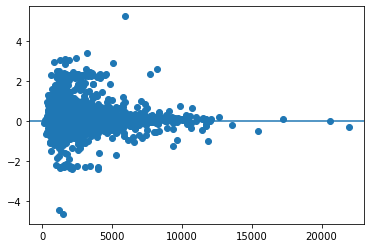

In [28]:
plt.scatter(df.sqft, df.logerror)

plt.axhline(y = 0)   

# Takeaway 


There appears to be a break in pattern around 5_000

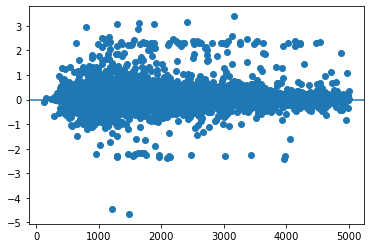

In [29]:
df_sqft_low = df[df.sqft < 5_000]

plt.scatter(df_sqft_low.sqft, df_sqft_low.logerror)

plt.axhline(y = 0)  

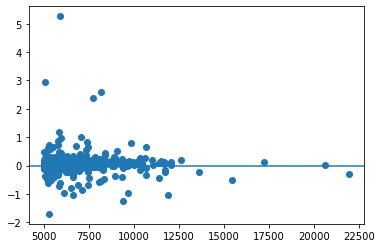

In [30]:
df_sqft_high = df[df.sqft > 5_000]

plt.scatter(df_sqft_high.sqft, df_sqft_high.logerror)

plt.axhline(y = 0) 

# Takeaway

it's still clustered around the horizontal line at zero

<AxesSubplot:xlabel='lot_sqft', ylabel='logerror'>

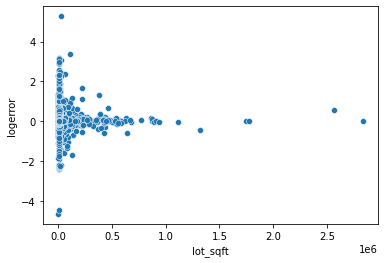

In [31]:
sns.scatterplot(df.lot_sqft, df.logerror)

In [32]:
# still centered around zero

# Other
How does log error change with propertycountylandusecode?

Similar trend of datapoints centered around zero.

<AxesSubplot:xlabel='propertycountylandusecode', ylabel='logerror'>

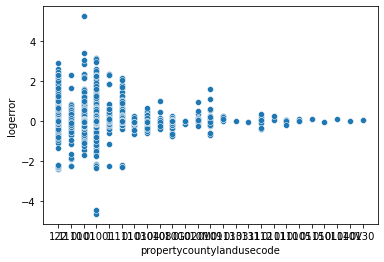

In [33]:
sns.scatterplot(df.propertycountylandusecode, df.logerror)

In [34]:
# Just a closer look

In [35]:
for col in df.columns:
    print(col)
    print(df[col].value_counts())
    print('----------------')

parcelid
14297519    1
10975547    1
17132574    1
12720855    1
12825799    1
           ..
11007650    1
11456032    1
13853386    1
13838216    1
12826780    1
Name: parcelid, Length: 51883, dtype: int64
----------------
logerror
 0.000727    5
 0.002652    5
 0.000231    5
 0.001878    5
 0.004645    4
            ..
-0.140079    1
-0.074333    1
 0.024347    1
 0.026154    1
 0.013209    1
Name: logerror, Length: 51628, dtype: int64
----------------
transactiondate
2017-06-30    799
2017-04-28    608
2017-05-31    561
2017-07-28    542
2017-08-31    521
             ... 
2017-05-20      1
2017-06-03      1
2017-06-11      1
2017-07-08      1
2017-09-25      1
Name: transactiondate, Length: 257, dtype: int64
----------------
bath
2.0     21758
3.0     10525
1.0      9482
2.5      3923
4.0      2153
3.5       907
1.5       831
5.0       770
4.5       681
6.0       299
5.5       222
0.0       107
7.0        87
8.0        52
6.5        46
7.5        16
9.0        12
10.0        5
11.0

(array([2.0000e+00, 0.0000e+00, 2.6000e+01, 1.0600e+02, 5.0416e+04,
        1.2040e+03, 7.5000e+01, 5.2000e+01, 1.0000e+00, 1.0000e+00]),
 array([-4.65542038, -3.66357847, -2.67173657, -1.67989467, -0.68805277,
         0.30378914,  1.29563104,  2.28747294,  3.27931484,  4.27115675,
         5.26299865]),
 <BarContainer object of 10 artists>)

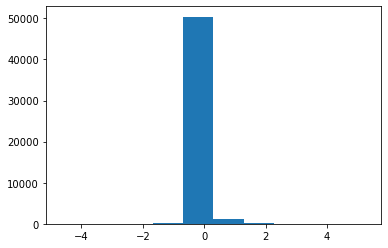

In [36]:
plt.hist(df.logerror)

In [37]:
df['absolute'] = df.logerror.abs()

In [38]:
df.absolute.sum()

3749.3524665313575

In [39]:
conditions = [(df['logerror'] > 0), (df['logerror'] <= 0)]

values = [1, 0]

df['rel_log'] = np.select(conditions, values)

In [40]:
df.head()

parcelid  logerror transactiondate  bath  bed    sqft    fips    latitude  \
0  14297519  0.025595      2017-01-01   3.5  4.0  3100.0  6059.0  33634931.0   
1  17052889  0.055619      2017-01-01   1.0  2.0  1465.0  6111.0  34449266.0   
2  14186244  0.005383      2017-01-01   2.0  3.0  1243.0  6059.0  33886168.0   
3  12177905 -0.103410      2017-01-01   3.0  4.0  2376.0  6037.0  34245180.0   
4  12095076 -0.001011      2017-01-01   3.0  4.0  2962.0  6037.0  34145202.0   

     longitude  lot_sqft propertycountylandusecode  rawcensustractandblock  \
0 -117869207.0    4506.0                       122            6.059063e+07   
1 -119281531.0   12647.0                      1110            6.111001e+07   
2 -117823170.0    8432.0                       122            6.059022e+07   
3 -118240722.0   13038.0                      0101            6.037300e+07   
4 -118179824.0   63000.0                      0101            6.037461e+07   

   regionidcity  regionidcounty      zip  yearbuilt  censustractandblock  \
0       53571.0          1286.0  96978.0     1998.0         6.059063e+13   
1       13091.0          2061.0  97099.0     1967.0         6.111001e+13   
2       21412.0          1286.0  97078.0     1962.0         6.059022e+13   
3      396551.0          3101.0  96330.0     1970.0         6.037300e+13   
4       47019.0          3101.0  96293.0     1950.0         6.037461e+13   

   absolute  rel_log  
0  0.025595        1  
1  0.055619        1  
2  0.005383        1  
3  0.103410        0  
4  0.001011        0

In [41]:
l = df[(df.logerror < .2) & (df.logerror > -.2)]

(array([  506.,   950.,  1838.,  4734., 13247., 16299.,  6281.,  2390.,
         1259.,   760.]),
 array([-1.99947136e-01, -1.59960757e-01, -1.19974377e-01, -7.99879970e-02,
        -4.00016172e-02, -1.52374460e-05,  3.99711423e-02,  7.99575221e-02,
         1.19943902e-01,  1.59930282e-01,  1.99916661e-01]),
 <BarContainer object of 10 artists>)

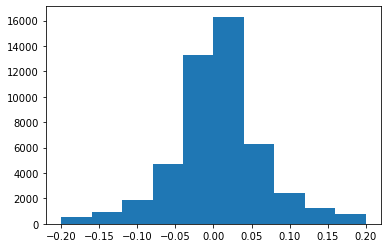

In [42]:
plt.hist(l.logerror)

In [43]:
#commeted out to save time in future runs
#sns.pairplot(df, corner = True, hue = 'rel_log')



# Pair Plot

Here's a picture of the pair plot in the previous cell so you don't have to wait for it to load

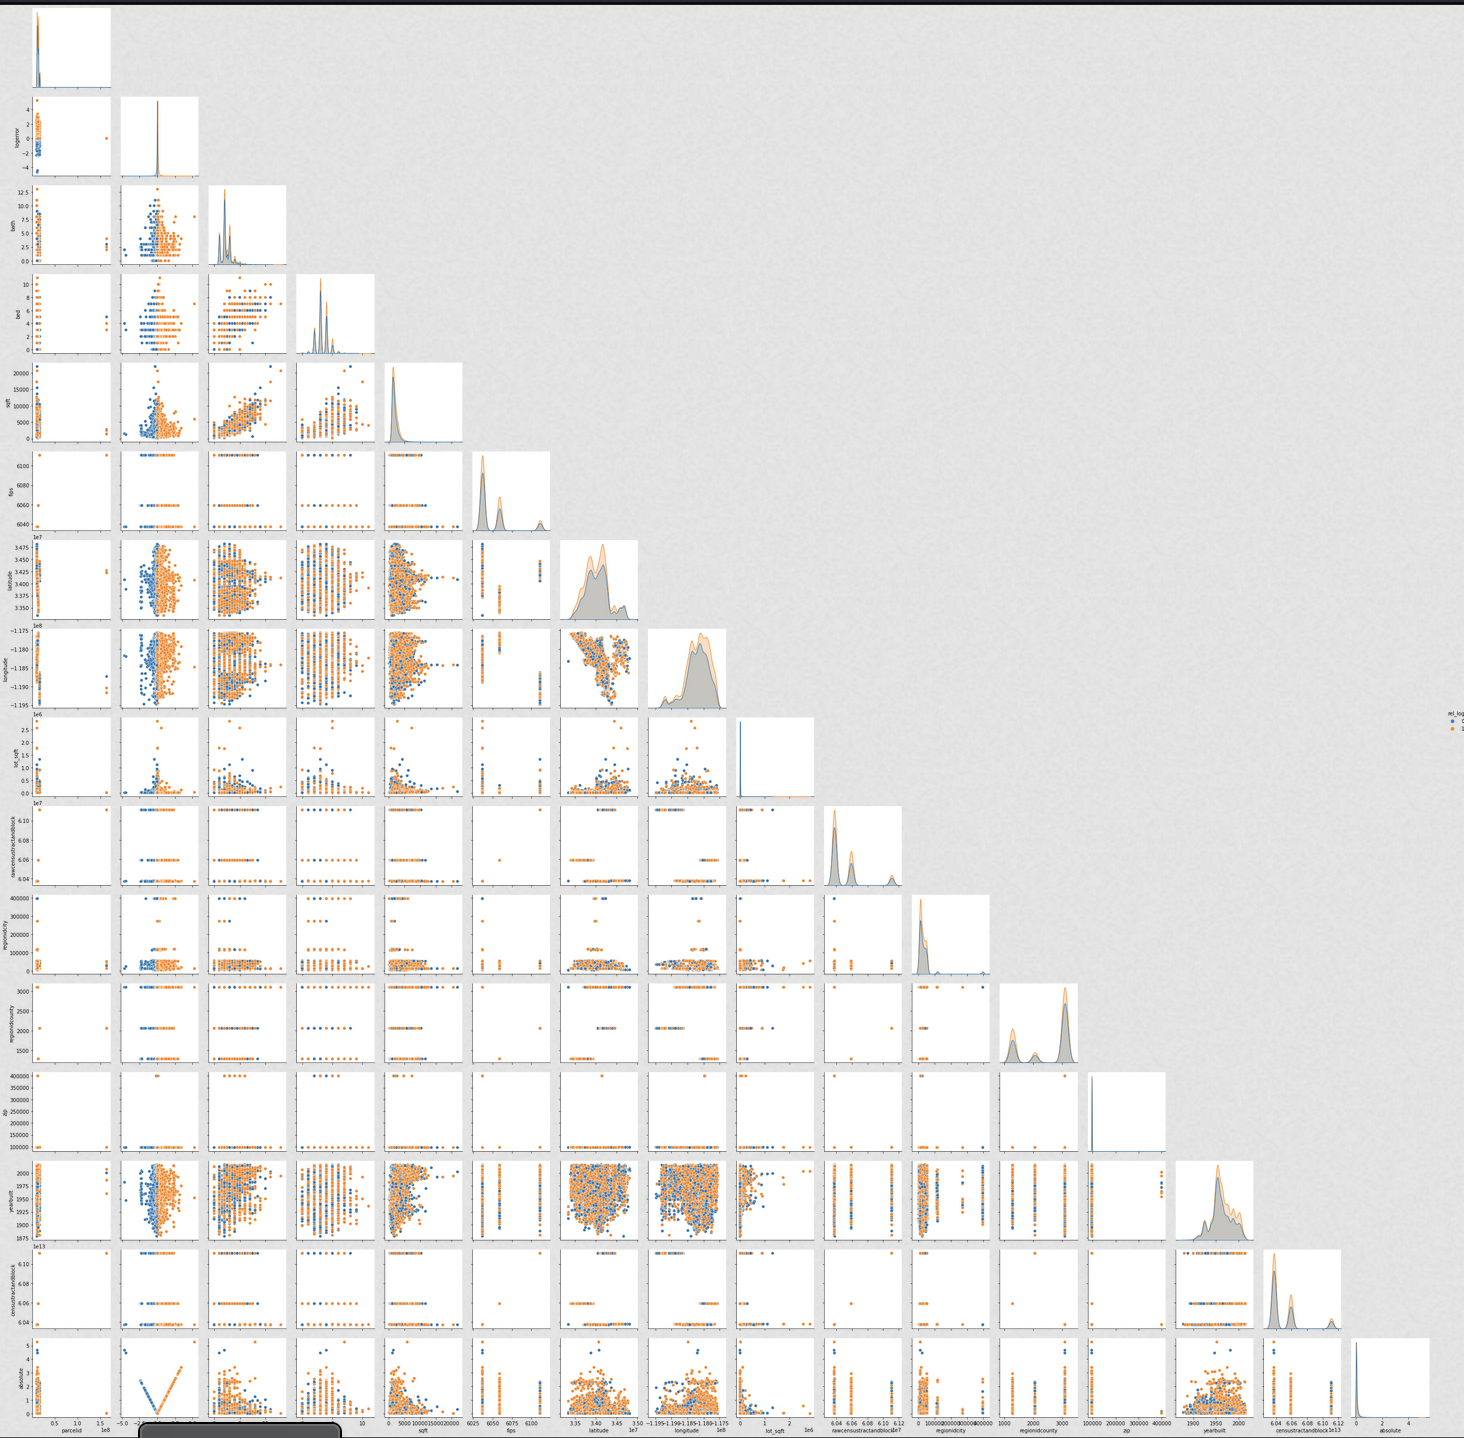


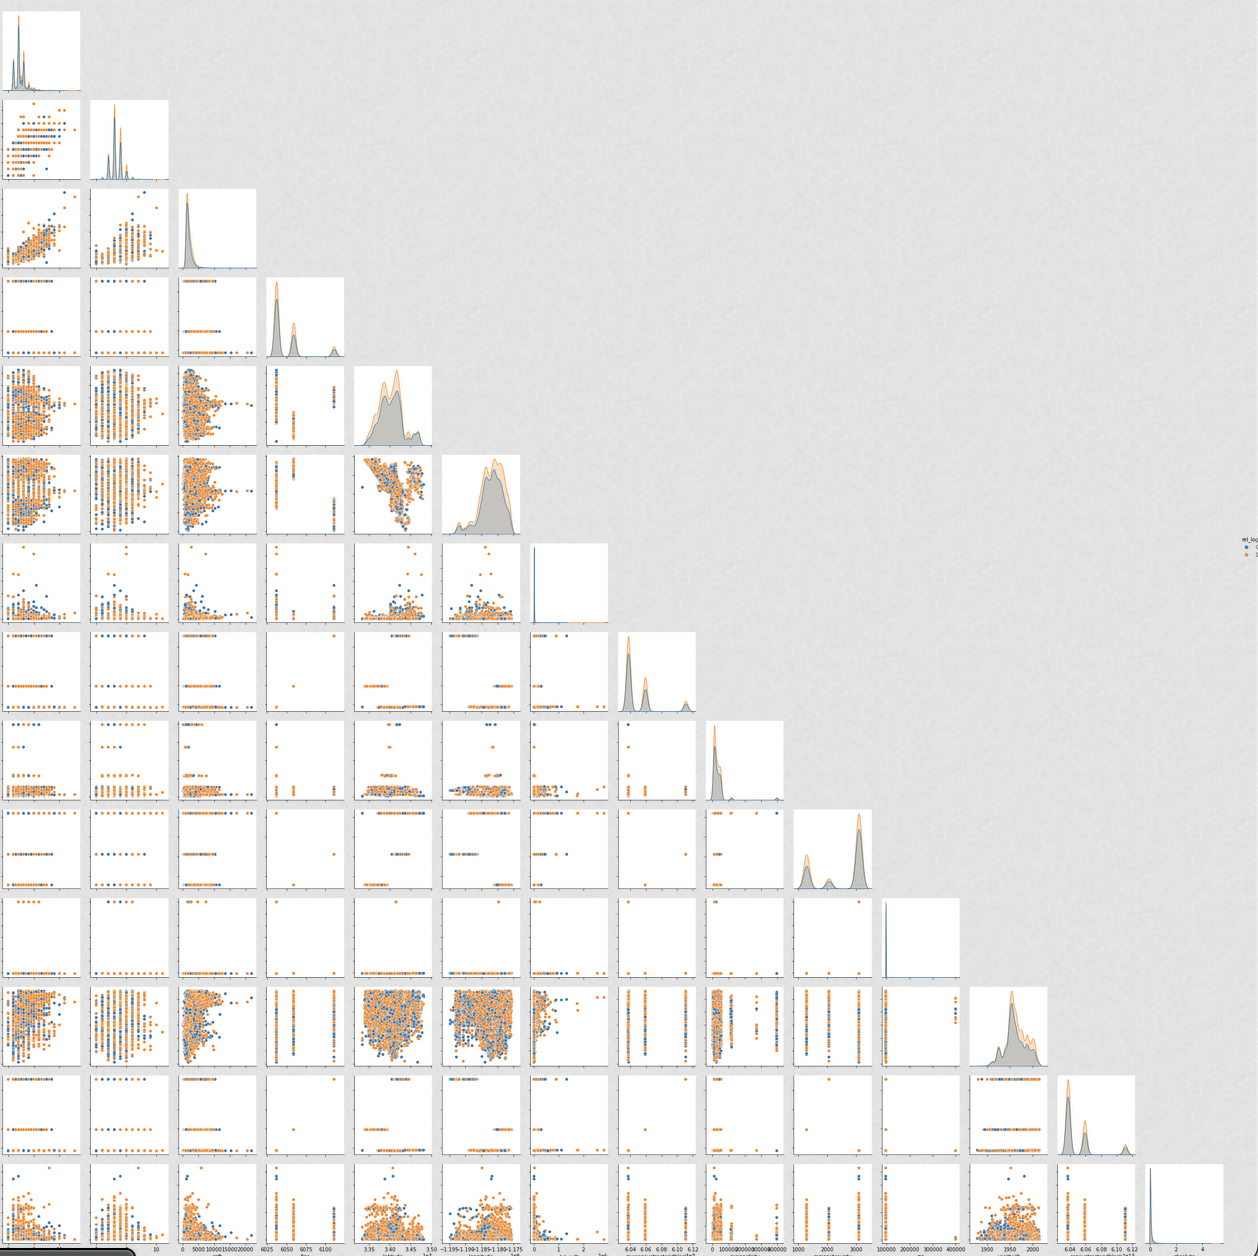

# Takeaway
I don't see anything that differentiates houses with low/high logerror.
And it seems that the houses are almost evenly divided into low/high logerror groups.

In [44]:
df.rel_log.value_counts()

1    29379
0    22504
Name: rel_log, dtype: int64

# Takeaway
I don't see anything that differentiates houses with low/high logerror.
And it seems that the houses are almost evenly divided into low/high logerror groups.

In [45]:
#commeted out ot save time on future reruns
#df_heat = df[['bath', 'bed', 'sqft', 'lot_sqft', 'logerror']]

In [46]:
#sns.heatmap(df_heat, annot = True, cmap = 'Blues')

# Clustering
scale the data first

# Scale: Robust and Standard
'sqft', 'yearbuilt', 'bath', 'bed', 'lot_sqft', 'bed_x_bath

In [47]:
labels

prime_id targert_variable      size             time             location  \
0  parcelid         logerror      bath        yearbuilt                  zip   
1                                  bed  transactiondate                 fips   
2                                 sqft                              latitude   
3                             lot_sqft                             longitude   
4                                                               regionidcity   
5                                                             regionidcounty   
6                                                        censustractandblock   

                       other  
0  propertycountylandusecode  
1                             
2                             
3                             
4                             
5                             
6

In [48]:
df['bed_x_bath'] = df.bed * df.bath

In [49]:
# gonna scale,  'bath, bed, sqft, lot_sqft, yearbuilt, 'bed_x_bath''

In [50]:
def split_data(df):
    train_validate, test = train_test_split(df, test_size=.2, random_state=51)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=51)
    return train, validate, test

In [51]:
from sklearn.preprocessing import StandardScaler

#Define function to scale all data based on the train subset
def ss_scale_data(train, validate, test):
    
    ss_cols = ['sqft', 'yearbuilt', 'bath', 'bed', 'lot_sqft', 'bed_x_bath']
    
    train_ss = train.copy()
    validate_ss = validate.copy()
    test_ss = test.copy()
    
    ss = StandardScaler()
    
    ss.fit(train[ss_cols]) # FIT ONLY on TRAIN
    
    train_ss[ss_cols] = ss.transform(train[ss_cols])
    validate_ss[ss_cols] = ss.transform(validate[ss_cols])
    test_ss[ss_cols] = ss.transform(test[ss_cols])
    
    return train_ss, validate_ss, test_ss

# Split
I am about to use an algorithim to learn from the data, so I must split the data first
20% Test

24% Validate

56% Train

In [52]:
train, validate, test = split_data(df)

In [53]:
df.shape, train.shape, validate.shape, test.shape

((51883, 20), (29054, 20), (12452, 20), (10377, 20))

In [54]:
train_ss, validate_ss, test_ss = ss_scale_data(train, validate, test)

In [55]:
x_train_ss = train_ss.drop(columns=['logerror'])
y_train_ss = train_ss.logerror

x_validate_ss = validate_ss.drop(columns=['logerror'])
y_validate_ss = validate_ss.logerror

x_test_ss = test_ss.drop(columns=['logerror'])
y_test_ss = test_ss.logerror

In [56]:
train_ss.head(3)

parcelid  logerror transactiondate      bath       bed      sqft  \
14166  11859679 -0.021764      2017-03-29 -0.290743  0.743767 -0.195711   
34345  11866752  0.009199      2017-06-27 -1.269791 -1.386289 -0.889946   
51345  12332016  0.040741      2017-09-12 -0.290743  0.743767 -0.141615   

         fips    latitude    longitude  lot_sqft propertycountylandusecode  \
14166  6037.0  34049495.0 -118090477.0 -0.174321                      0100   
34345  6037.0  34071300.0 -118073869.0 -0.140352                      0100   
51345  6037.0  33946639.0 -118124583.0 -0.067528                      0100   

       rawcensustractandblock  regionidcity  regionidcounty      zip  \
14166            6.037483e+07       54212.0          3101.0  96510.0   
34345            6.037434e+07       54212.0          3101.0  96510.0   
51345            6.037551e+07        4406.0          3101.0  96101.0   

       yearbuilt  censustractandblock  absolute  rel_log  bed_x_bath  
14166   0.120493         6.037483e+13  0.021764        0   -0.035364  
34345  -0.579333         6.037434e+13  0.009199        1   -1.070232  
51345  -0.141942         6.037551e+13  0.040741        1   -0.035364

In [57]:
# 2nt type scaler 

In [58]:
#Define function to scale all data based on the train subset
def robust_scale_data(train, validate, test):
    
    rs_cols = ['sqft', 'yearbuilt', 'bath', 'bed', 'lot_sqft', 'bed_x_bath']
    
    train_rs = train.copy()
    validate_rs = validate.copy()
    test_rs = test.copy()
    
    rs = RobustScaler()
    
    rs.fit(train[rs_cols]) # FIT ONLY on TRAIN
    
    train_rs[rs_cols] = rs.transform(train[rs_cols])
    validate_rs[rs_cols] = rs.transform(validate[rs_cols])
    test_rs[rs_cols] = rs.transform(test[rs_cols])
    
    return train_rs, validate_rs, test_rs

In [59]:
train_rs, validate_rs, test_rs = robust_scale_data(train, validate, test)

In [60]:
x_train_rs = train_rs.drop(columns=['logerror'])
y_train_rs = train_rs.logerror

x_validate_rs = validate_rs.drop(columns=['logerror'])
y_validate_rs = validate_rs.logerror

x_test_rs = test_rs.drop(columns=['logerror'])
y_test_rs = test_rs.logerror

In [224]:
train.head()

parcelid  logerror transactiondate  bath  bed    sqft    fips  \
14166  11859679 -0.021764      2017-03-29   2.0  4.0  1725.0  6037.0   
34345  11866752  0.009199      2017-06-27   1.0  2.0  1032.0  6037.0   
51345  12332016  0.040741      2017-09-12   2.0  4.0  1779.0  6037.0   
5495   11423282  0.013744      2017-02-06   2.0  3.0  1440.0  6037.0   
35164  12319787  0.062963      2017-06-29   2.0  3.0  1690.0  6037.0   

         latitude    longitude  lot_sqft propertycountylandusecode  \
14166  34049495.0 -118090477.0    5041.0                      0100   
34345  34071300.0 -118073869.0    6049.0                      0100   
51345  33946639.0 -118124583.0    8210.0                      0100   
5495   33924819.0 -118338285.0    5565.0                      0100   
35164  33942461.0 -118152248.0    7518.0                      0100   

       rawcensustractandblock  regionidcity  regionidcounty      zip  \
14166            6.037483e+07       54212.0          3101.0  96510.0   
34345            6.037434e+07       54212.0          3101.0  96510.0   
51345            6.037551e+07        4406.0          3101.0  96101.0   
5495             6.037602e+07       42150.0          3101.0  96107.0   
35164            6.037551e+07        4406.0          3101.0  96101.0   

       yearbuilt  censustractandblock  absolute  rel_log  bed_x_bath  
14166     1966.0         6.037483e+13  0.021764        0         8.0  
34345     1950.0         6.037434e+13  0.009199        1         2.0  
51345     1960.0         6.037551e+13  0.040741        1         8.0  
5495      1965.0         6.037602e+13  0.013744        1         6.0  
35164     1975.0         6.037551e+13  0.062963        1         6.0

In [225]:
train_ss.head()

parcelid  logerror transactiondate      bath       bed      sqft  \
14166  11859679 -0.021764      2017-03-29 -0.290743  0.743767 -0.195711   
34345  11866752  0.009199      2017-06-27 -1.269791 -1.386289 -0.889946   
51345  12332016  0.040741      2017-09-12 -0.290743  0.743767 -0.141615   
5495   11423282  0.013744      2017-02-06 -0.290743 -0.321261 -0.481219   
35164  12319787  0.062963      2017-06-29 -0.290743 -0.321261 -0.230773   

         fips    latitude    longitude  lot_sqft propertycountylandusecode  \
14166  6037.0  34049495.0 -118090477.0 -0.174321                      0100   
34345  6037.0  34071300.0 -118073869.0 -0.140352                      0100   
51345  6037.0  33946639.0 -118124583.0 -0.067528                      0100   
5495   6037.0  33924819.0 -118338285.0 -0.156662                      0100   
35164  6037.0  33942461.0 -118152248.0 -0.090848                      0100   

       rawcensustractandblock  regionidcity  regionidcounty      zip  \
14166            6.037483e+07       54212.0          3101.0  96510.0   
34345            6.037434e+07       54212.0          3101.0  96510.0   
51345            6.037551e+07        4406.0          3101.0  96101.0   
5495             6.037602e+07       42150.0          3101.0  96107.0   
35164            6.037551e+07        4406.0          3101.0  96101.0   

       yearbuilt  censustractandblock  absolute  rel_log  bed_x_bath  
14166   0.120493         6.037483e+13  0.021764        0   -0.035364  
34345  -0.579333         6.037434e+13  0.009199        1   -1.070232  
51345  -0.141942         6.037551e+13  0.040741        1   -0.035364  
5495    0.076753         6.037602e+13  0.013744        1   -0.380320  
35164   0.514145         6.037551e+13  0.062963        1   -0.380320

In [226]:
train_rs.head()

parcelid  logerror transactiondate  bath  bed      sqft    fips  \
14166  11859679 -0.021764      2017-03-29   0.0  1.0  0.064922  6037.0   
34345  11866752  0.009199      2017-06-27  -1.0 -1.0 -0.606589  6037.0   
51345  12332016  0.040741      2017-09-12   0.0  1.0  0.117248  6037.0   
5495   11423282  0.013744      2017-02-06   0.0  0.0 -0.211240  6037.0   
35164  12319787  0.062963      2017-06-29   0.0  0.0  0.031008  6037.0   

         latitude    longitude  lot_sqft propertycountylandusecode  \
14166  34049495.0 -118090477.0 -0.562859                      0100   
34345  34071300.0 -118073869.0 -0.249573                      0100   
51345  33946639.0 -118124583.0  0.422067                      0100   
5495   33924819.0 -118338285.0 -0.400000                      0100   
35164  33942461.0 -118152248.0  0.206993                      0100   

       rawcensustractandblock  regionidcity  regionidcounty      zip  \
14166            6.037483e+07       54212.0          3101.0  96510.0   
34345            6.037434e+07       54212.0          3101.0  96510.0   
51345            6.037551e+07        4406.0          3101.0  96101.0   
5495             6.037602e+07       42150.0          3101.0  96107.0   
35164            6.037551e+07        4406.0          3101.0  96101.0   

       yearbuilt  censustractandblock  absolute  rel_log  bed_x_bath  
14166   0.206897         6.037483e+13  0.021764        0         0.4  
34345  -0.344828         6.037434e+13  0.009199        1        -0.8  
51345   0.000000         6.037551e+13  0.040741        1         0.4  
5495    0.172414         6.037602e+13  0.013744        1         0.0  
35164   0.517241         6.037551e+13  0.062963        1         0.0

(-2.0, 15.0)

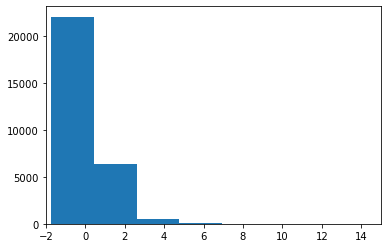

In [232]:
plt.hist(x_train_ss.sqft)
plt.xlim(-2,15)

(-2.0, 15.0)

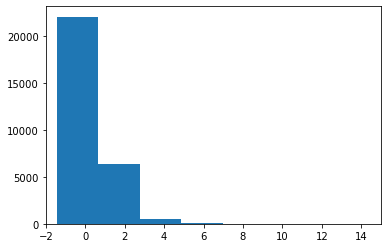

In [233]:
plt.hist(x_train_rs.sqft)
plt.xlim(-2,15)

In [61]:
# Clusters-location, size, transactiondate
labels

prime_id targert_variable      size             time             location  \
0  parcelid         logerror      bath        yearbuilt                  zip   
1                                  bed  transactiondate                 fips   
2                                 sqft                              latitude   
3                             lot_sqft                             longitude   
4                                                               regionidcity   
5                                                             regionidcounty   
6                                                        censustractandblock   

                       other  
0  propertycountylandusecode  
1                             
2                             
3                             
4                             
5                             
6

# #1 Location cluster
'regionidcity', 'regionidcounty', 'zip', censustractandblock', 'fips'

In [62]:
labels

prime_id targert_variable      size             time             location  \
0  parcelid         logerror      bath        yearbuilt                  zip   
1                                  bed  transactiondate                 fips   
2                                 sqft                              latitude   
3                             lot_sqft                             longitude   
4                                                               regionidcity   
5                                                             regionidcounty   
6                                                        censustractandblock   

                       other  
0  propertycountylandusecode  
1                             
2                             
3                             
4                             
5                             
6

In [63]:
x_train_ss.columns

Index(['parcelid', 'transactiondate', 'bath', 'bed', 'sqft', 'fips',
       'latitude', 'longitude', 'lot_sqft', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'yearbuilt', 'censustractandblock', 'absolute', 'rel_log',
       'bed_x_bath'],
      dtype='object')

In [64]:
x_train_ss_location = x_train_ss[['regionidcity', 'regionidcounty', 'zip',
                              'censustractandblock', 'fips']]
                              
# I did not do lat and long, because they feel like half potatoes                             

In [65]:
x_validate_ss_location = x_validate_ss[['regionidcity', 'regionidcounty', 'zip',
                              'censustractandblock', 'fips']]
                              
# I did not do lat and long, because they feel like half potatoes   

In [66]:
x_test_ss_location = x_test_ss[['regionidcity', 'regionidcounty', 'zip',
                              'censustractandblock', 'fips']]
                              
# I did not do lat and long, because they feel like half potatoes   

In [67]:
#set hyperperameters
kmeans = KMeans(n_clusters=3)
#fit ONLY to train. computer may only learn from train
kmeans.fit(x_train_ss_location)

#find predictions
clusters = kmeans.predict(x_train_ss_location)
clusters_v = kmeans.predict(x_validate_ss_location)
clusters_t = kmeans.predict(x_test_ss_location)
clusters

array([0, 0, 0, ..., 0, 2, 0], dtype=int32)

In [68]:
clusters.shape, clusters_v.shape, clusters_t.shape

((29054,), (12452,), (10377,))

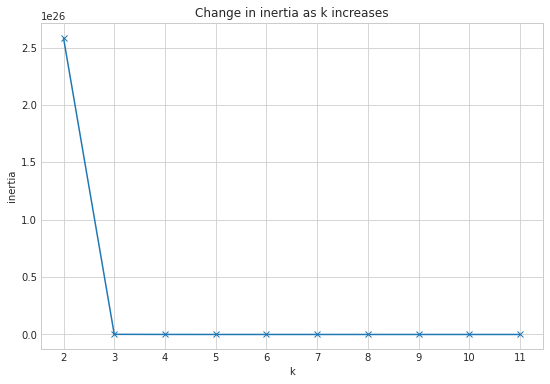

In [69]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(x_train_ss_location).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

# Takeaway
Three is the most acute angle

In [70]:
#add it to set
x_train_ss['cluster_location'] = clusters
x_validate_ss['cluster_location'] = clusters_v
x_test_ss['cluster_location'] = clusters_t
x_train_ss.head()

parcelid transactiondate      bath       bed      sqft    fips  \
14166  11859679      2017-03-29 -0.290743  0.743767 -0.195711  6037.0   
34345  11866752      2017-06-27 -1.269791 -1.386289 -0.889946  6037.0   
51345  12332016      2017-09-12 -0.290743  0.743767 -0.141615  6037.0   
5495   11423282      2017-02-06 -0.290743 -0.321261 -0.481219  6037.0   
35164  12319787      2017-06-29 -0.290743 -0.321261 -0.230773  6037.0   

         latitude    longitude  lot_sqft propertycountylandusecode  \
14166  34049495.0 -118090477.0 -0.174321                      0100   
34345  34071300.0 -118073869.0 -0.140352                      0100   
51345  33946639.0 -118124583.0 -0.067528                      0100   
5495   33924819.0 -118338285.0 -0.156662                      0100   
35164  33942461.0 -118152248.0 -0.090848                      0100   

       rawcensustractandblock  regionidcity  regionidcounty      zip  \
14166            6.037483e+07       54212.0          3101.0  96510.0   
34345            6.037434e+07       54212.0          3101.0  96510.0   
51345            6.037551e+07        4406.0          3101.0  96101.0   
5495             6.037602e+07       42150.0          3101.0  96107.0   
35164            6.037551e+07        4406.0          3101.0  96101.0   

       yearbuilt  censustractandblock  absolute  rel_log  bed_x_bath  \
14166   0.120493         6.037483e+13  0.021764        0   -0.035364   
34345  -0.579333         6.037434e+13  0.009199        1   -1.070232   
51345  -0.141942         6.037551e+13  0.040741        1   -0.035364   
5495    0.076753         6.037602e+13  0.013744        1   -0.380320   
35164   0.514145         6.037551e+13  0.062963        1   -0.380320   

       cluster_location  
14166                 0  
34345                 0  
51345                 0  
5495                  0  
35164                 0

In [71]:
#Standard Scale
x_train_ss.cluster_location.value_counts()

0    18756
2     7855
1     2443
Name: cluster_location, dtype: int64

# Same thing for robust scaled data

In [72]:
x_train_rs_location = x_train_rs[['regionidcity', 'regionidcounty', 'zip',
                              'censustractandblock', 'fips']]
                              
# I did not do lat and long, because they feel like half potatoes                             

In [73]:
x_validate_rs_location = x_validate_rs[['regionidcity', 'regionidcounty', 'zip',
                              'censustractandblock', 'fips']]
                              
# I did not do lat and long, because they feel like half potatoes   

In [74]:
x_test_rs_location = x_test_rs[['regionidcity', 'regionidcounty', 'zip',
                              'censustractandblock', 'fips']]
                              
# I did not do lat and long, because they feel like half potatoes   

In [75]:
#set hyperperameters
kmeans = KMeans(n_clusters=3)
#fit ONLY to train. computer may only learn from train
kmeans.fit(x_train_rs_location)

#find predictions
clusters_r = kmeans.predict(x_train_rs_location)
clusters_rv = kmeans.predict(x_validate_rs_location)
clusters_rt = kmeans.predict(x_test_rs_location)
clusters_r

array([0, 0, 0, ..., 0, 2, 0], dtype=int32)

In [76]:
clusters_r.shape, clusters_rv.shape, clusters_rt.shape

((29054,), (12452,), (10377,))

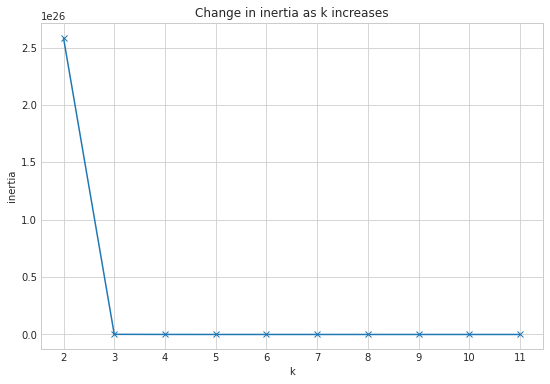

In [77]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(x_train_rs_location).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

# Takeaway
Three is the most acute angle

In [78]:
#add it to set
x_train_rs['cluster_location'] = clusters_r
x_validate_rs['cluster_location'] = clusters_rv
x_test_rs['cluster_location'] = clusters_rt
x_train_rs.head()

parcelid transactiondate  bath  bed      sqft    fips    latitude  \
14166  11859679      2017-03-29   0.0  1.0  0.064922  6037.0  34049495.0   
34345  11866752      2017-06-27  -1.0 -1.0 -0.606589  6037.0  34071300.0   
51345  12332016      2017-09-12   0.0  1.0  0.117248  6037.0  33946639.0   
5495   11423282      2017-02-06   0.0  0.0 -0.211240  6037.0  33924819.0   
35164  12319787      2017-06-29   0.0  0.0  0.031008  6037.0  33942461.0   

         longitude  lot_sqft propertycountylandusecode  \
14166 -118090477.0 -0.562859                      0100   
34345 -118073869.0 -0.249573                      0100   
51345 -118124583.0  0.422067                      0100   
5495  -118338285.0 -0.400000                      0100   
35164 -118152248.0  0.206993                      0100   

       rawcensustractandblock  regionidcity  regionidcounty      zip  \
14166            6.037483e+07       54212.0          3101.0  96510.0   
34345            6.037434e+07       54212.0          3101.0  96510.0   
51345            6.037551e+07        4406.0          3101.0  96101.0   
5495             6.037602e+07       42150.0          3101.0  96107.0   
35164            6.037551e+07        4406.0          3101.0  96101.0   

       yearbuilt  censustractandblock  absolute  rel_log  bed_x_bath  \
14166   0.206897         6.037483e+13  0.021764        0         0.4   
34345  -0.344828         6.037434e+13  0.009199        1        -0.8   
51345   0.000000         6.037551e+13  0.040741        1         0.4   
5495    0.172414         6.037602e+13  0.013744        1         0.0   
35164   0.517241         6.037551e+13  0.062963        1         0.0   

       cluster_location  
14166                 0  
34345                 0  
51345                 0  
5495                  0  
35164                 0

In [218]:
#Robust Scale
x_train_rs.cluster_location.value_counts()

0    18756
2     7855
1     2443
Name: cluster_location, dtype: int64

# #2 Size Cluster
'bath', 'bed', 'sqft', 'lot_sqft'

In [80]:
x_train_ss.columns

Index(['parcelid', 'transactiondate', 'bath', 'bed', 'sqft', 'fips',
       'latitude', 'longitude', 'lot_sqft', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'yearbuilt', 'censustractandblock', 'absolute', 'rel_log', 'bed_x_bath',
       'cluster_location'],
      dtype='object')

In [81]:
x_train_ss_size = x_train_ss[['bath', 'bed', 'sqft', 'lot_sqft']]

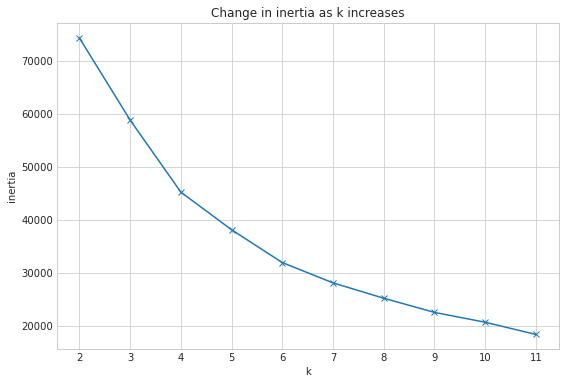

In [82]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(x_train_ss_size).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

# Takeaway
I think 4 is most acute

# Robust Scale

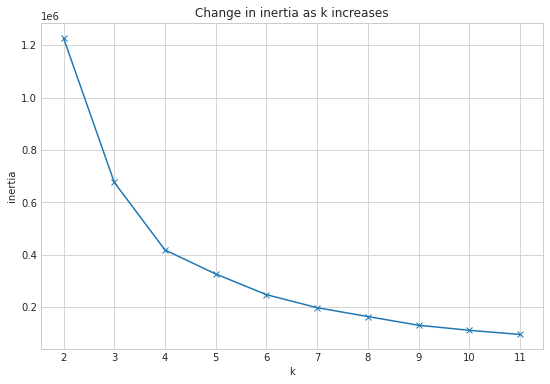

In [83]:
x_train_rs_size = x_train_rs[['bath', 'bed', 'sqft', 'lot_sqft']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(x_train_rs_size).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

# Takeaway
I think 4 is most acute

# Takeaway
I'm not going to add it. 
It will replace 1 encoded and 3 continuos columns with 4 encoded 
I think I will try to feature engineer a different route to deal with bathrooms



# #3 Time Sold Cluster
'transactiondate'

In [84]:
x_train_ss.columns

Index(['parcelid', 'transactiondate', 'bath', 'bed', 'sqft', 'fips',
       'latitude', 'longitude', 'lot_sqft', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'yearbuilt', 'censustractandblock', 'absolute', 'rel_log', 'bed_x_bath',
       'cluster_location'],
      dtype='object')

In [85]:
x_train_ss_sold = x_train_ss[['transactiondate']]

In [86]:
x_train_ss_sold=x_train_ss_sold.astype('str')

In [87]:
x_train_ss_sold.head(3)

transactiondate
14166      2017-03-29
34345      2017-06-27
51345      2017-09-12

In [88]:
x_train_ss_sold = x_train_ss_sold.transactiondate.str.replace('2017-', '')

In [89]:
x_train_ss_sold.head(3)

14166    03-29
34345    06-27
51345    09-12
Name: transactiondate, dtype: object

In [90]:
x_train_ss_sold = x_train_ss_sold.str.replace('-', '.')

In [91]:
x_train_ss_sold = x_train_ss_sold.astype('float')

In [92]:
x_train_ss_sold.head(3)

14166    3.29
34345    6.27
51345    9.12
Name: transactiondate, dtype: float64

In [93]:
x_train_ss_sold=pd.DataFrame(x_train_ss_sold)

In [94]:
x_validate_ss_sold = x_validate_ss[['transactiondate']]

In [95]:
x_validate_ss_sold=x_validate_ss_sold.astype('str')

In [96]:
x_validate_ss_sold = x_validate_ss_sold.transactiondate.str.replace('2017-', '')

In [97]:
x_validate_ss_sold = x_validate_ss_sold.str.replace('-', '.')

In [98]:
x_validate_ss_sold = x_validate_ss_sold.astype('float')

In [99]:
x_validate_ss_sold=pd.DataFrame(x_validate_ss_sold)

In [100]:
x_test_ss_sold = x_test_ss[['transactiondate']]

In [101]:
x_test_ss_sold=x_test_ss_sold.astype('str')

In [102]:
x_test_ss_sold = x_test_ss_sold.transactiondate.str.replace('2017-', '')

In [103]:
x_test_ss_sold = x_test_ss_sold.str.replace('-', '.')

In [104]:
x_test_ss_sold = x_test_ss_sold.astype('float')

In [105]:
x_test_ss_sold=pd.DataFrame(x_test_ss_sold)

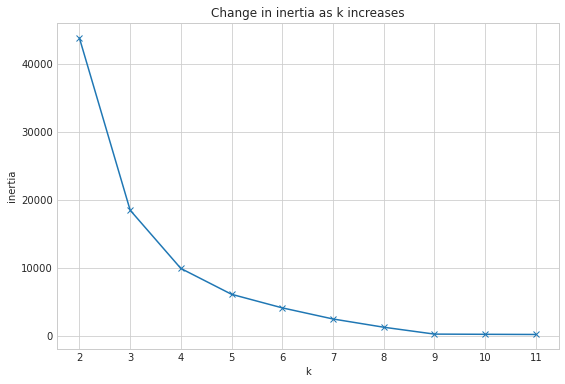

In [106]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(x_train_ss_sold).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [107]:
# I think 3 is most acute, closely followed by 4

In [108]:
#set hyperperameters
kmeans = KMeans(n_clusters=3)
#fit ONLY to train. computer may only learn from train
kmeans.fit(x_train_ss_sold)

#find predictions
clusters = kmeans.predict(x_train_ss_sold)
clusters_v = kmeans.predict(x_validate_ss_sold)
clusters_t = kmeans.predict(x_test_ss_sold)
clusters

array([2, 0, 1, ..., 2, 0, 2], dtype=int32)

In [109]:
#add it to the training set
x_train_ss['cluster_sold'] = clusters
x_validate_ss['cluster_sold'] = clusters_v
x_test_ss['cluster_sold'] = clusters_t
x_train_ss.head()

parcelid transactiondate      bath       bed      sqft    fips  \
14166  11859679      2017-03-29 -0.290743  0.743767 -0.195711  6037.0   
34345  11866752      2017-06-27 -1.269791 -1.386289 -0.889946  6037.0   
51345  12332016      2017-09-12 -0.290743  0.743767 -0.141615  6037.0   
5495   11423282      2017-02-06 -0.290743 -0.321261 -0.481219  6037.0   
35164  12319787      2017-06-29 -0.290743 -0.321261 -0.230773  6037.0   

         latitude    longitude  lot_sqft propertycountylandusecode  \
14166  34049495.0 -118090477.0 -0.174321                      0100   
34345  34071300.0 -118073869.0 -0.140352                      0100   
51345  33946639.0 -118124583.0 -0.067528                      0100   
5495   33924819.0 -118338285.0 -0.156662                      0100   
35164  33942461.0 -118152248.0 -0.090848                      0100   

       rawcensustractandblock  regionidcity  regionidcounty      zip  \
14166            6.037483e+07       54212.0          3101.0  96510.0   
34345            6.037434e+07       54212.0          3101.0  96510.0   
51345            6.037551e+07        4406.0          3101.0  96101.0   
5495             6.037602e+07       42150.0          3101.0  96107.0   
35164            6.037551e+07        4406.0          3101.0  96101.0   

       yearbuilt  censustractandblock  absolute  rel_log  bed_x_bath  \
14166   0.120493         6.037483e+13  0.021764        0   -0.035364   
34345  -0.579333         6.037434e+13  0.009199        1   -1.070232   
51345  -0.141942         6.037551e+13  0.040741        1   -0.035364   
5495    0.076753         6.037602e+13  0.013744        1   -0.380320   
35164   0.514145         6.037551e+13  0.062963        1   -0.380320   

       cluster_location  cluster_sold  
14166                 0             2  
34345                 0             0  
51345                 0             1  
5495                  0             2  
35164                 0             0

In [110]:
#Standard Scaler Clusters
x_train_ss.cluster_sold.value_counts()

0    11567
1     9063
2     8424
Name: cluster_sold, dtype: int64

# Same for robust scaler

In [111]:
x_train_rs_sold = x_train_rs[['transactiondate']]

In [112]:
x_train_rs_sold=x_train_rs_sold.astype('str')

In [113]:
x_train_rs_sold.head(3)

transactiondate
14166      2017-03-29
34345      2017-06-27
51345      2017-09-12

In [114]:
x_train_rs_sold = x_train_rs_sold.transactiondate.str.replace('2017-', '')

In [115]:
x_train_rs_sold.head(3)

14166    03-29
34345    06-27
51345    09-12
Name: transactiondate, dtype: object

In [116]:
x_train_rs_sold = x_train_rs_sold.str.replace('-', '.')

In [117]:
x_train_rs_sold = x_train_rs_sold.astype('float')

In [118]:
x_train_rs_sold.head(3)

14166    3.29
34345    6.27
51345    9.12
Name: transactiondate, dtype: float64

In [119]:
x_train_rs_sold=pd.DataFrame(x_train_rs_sold)

In [120]:
x_validate_rs_sold = x_validate_rs[['transactiondate']]

In [121]:
x_validate_rs_sold=x_validate_rs_sold.astype('str')

In [122]:
x_validate_rs_sold = x_validate_rs_sold.transactiondate.str.replace('2017-', '')

In [123]:
x_validate_rs_sold = x_validate_rs_sold.str.replace('-', '.')

In [124]:
x_validate_rs_sold = x_validate_rs_sold.astype('float')

In [125]:
x_validate_rs_sold=pd.DataFrame(x_validate_rs_sold)

In [126]:
x_test_rs_sold = x_test_rs[['transactiondate']]

In [127]:
x_test_rs_sold=x_test_rs_sold.astype('str')

In [128]:
x_test_rs_sold = x_test_rs_sold.transactiondate.str.replace('2017-', '')

In [129]:
x_test_rs_sold = x_test_rs_sold.str.replace('-', '.')

In [130]:
x_test_rs_sold = x_test_rs_sold.astype('float')

In [131]:
x_test_rs_sold=pd.DataFrame(x_test_rs_sold)

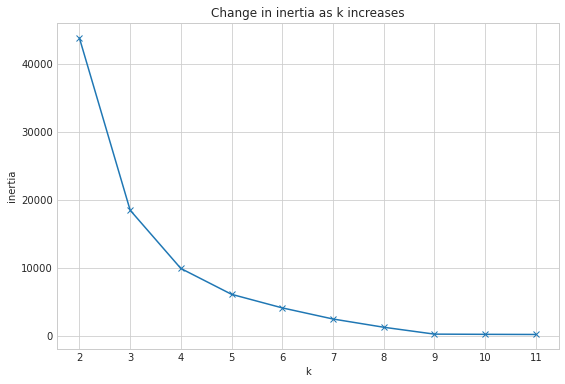

In [132]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(x_train_rs_sold).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

# Takeaway
I think 3 is most acute, closely followed by 4

In [133]:
#set hyperperameters
kmeans = KMeans(n_clusters=3)
#fit ONLY to train. computer may only learn from train
kmeans.fit(x_train_rs_sold)

#find predictions
clusters_r = kmeans.predict(x_train_rs_sold)
clusters_rv = kmeans.predict(x_validate_rs_sold)
clusters_rt = kmeans.predict(x_test_rs_sold)
clusters_r

array([1, 0, 2, ..., 1, 0, 1], dtype=int32)

In [134]:
#add it to the training set
x_train_rs['cluster_sold'] = clusters_r
x_validate_rs['cluster_sold'] = clusters_rv
x_test_rs['cluster_sold'] = clusters_rt
x_train_rs.head()

parcelid transactiondate  bath  bed      sqft    fips    latitude  \
14166  11859679      2017-03-29   0.0  1.0  0.064922  6037.0  34049495.0   
34345  11866752      2017-06-27  -1.0 -1.0 -0.606589  6037.0  34071300.0   
51345  12332016      2017-09-12   0.0  1.0  0.117248  6037.0  33946639.0   
5495   11423282      2017-02-06   0.0  0.0 -0.211240  6037.0  33924819.0   
35164  12319787      2017-06-29   0.0  0.0  0.031008  6037.0  33942461.0   

         longitude  lot_sqft propertycountylandusecode  \
14166 -118090477.0 -0.562859                      0100   
34345 -118073869.0 -0.249573                      0100   
51345 -118124583.0  0.422067                      0100   
5495  -118338285.0 -0.400000                      0100   
35164 -118152248.0  0.206993                      0100   

       rawcensustractandblock  regionidcity  regionidcounty      zip  \
14166            6.037483e+07       54212.0          3101.0  96510.0   
34345            6.037434e+07       54212.0          3101.0  96510.0   
51345            6.037551e+07        4406.0          3101.0  96101.0   
5495             6.037602e+07       42150.0          3101.0  96107.0   
35164            6.037551e+07        4406.0          3101.0  96101.0   

       yearbuilt  censustractandblock  absolute  rel_log  bed_x_bath  \
14166   0.206897         6.037483e+13  0.021764        0         0.4   
34345  -0.344828         6.037434e+13  0.009199        1        -0.8   
51345   0.000000         6.037551e+13  0.040741        1         0.4   
5495    0.172414         6.037602e+13  0.013744        1         0.0   
35164   0.517241         6.037551e+13  0.062963        1         0.0   

       cluster_location  cluster_sold  
14166                 0             1  
34345                 0             0  
51345                 0             2  
5495                  0             1  
35164                 0             0

In [135]:
# Robust Scaler Clusters
x_train_rs.cluster_sold.value_counts()

0    11567
2     9063
1     8424
Name: cluster_sold, dtype: int64

# filter whats actually going into models

In [136]:
x_train_ss.columns

Index(['parcelid', 'transactiondate', 'bath', 'bed', 'sqft', 'fips',
       'latitude', 'longitude', 'lot_sqft', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'yearbuilt', 'censustractandblock', 'absolute', 'rel_log', 'bed_x_bath',
       'cluster_location', 'cluster_sold'],
      dtype='object')

In [137]:
x_trss_model = x_train_ss[['bed_x_bath', 'sqft', 'lot_sqft', 
                           'yearbuilt', 
                           'cluster_location', 'cluster_sold']]

x_trrs_model = x_train_rs[['bed_x_bath', 'sqft', 'lot_sqft', 
                           'yearbuilt', 
                           'cluster_location', 'cluster_sold']]


In [138]:
x_trss_model.head()

bed_x_bath      sqft  lot_sqft  yearbuilt  cluster_location  \
14166   -0.035364 -0.195711 -0.174321   0.120493                 0   
34345   -1.070232 -0.889946 -0.140352  -0.579333                 0   
51345   -0.035364 -0.141615 -0.067528  -0.141942                 0   
5495    -0.380320 -0.481219 -0.156662   0.076753                 0   
35164   -0.380320 -0.230773 -0.090848   0.514145                 0   

       cluster_sold  
14166             2  
34345             0  
51345             1  
5495              2  
35164             0

In [139]:
x_trss_model = pd.get_dummies(x_trss_model, columns = ['cluster_location', 'cluster_sold'], dummy_na=False, drop_first= False)
x_trss_model.head()

bed_x_bath      sqft  lot_sqft  yearbuilt  cluster_location_0  \
14166   -0.035364 -0.195711 -0.174321   0.120493                   1   
34345   -1.070232 -0.889946 -0.140352  -0.579333                   1   
51345   -0.035364 -0.141615 -0.067528  -0.141942                   1   
5495    -0.380320 -0.481219 -0.156662   0.076753                   1   
35164   -0.380320 -0.230773 -0.090848   0.514145                   1   

       cluster_location_1  cluster_location_2  cluster_sold_0  cluster_sold_1  \
14166                   0                   0               0               0   
34345                   0                   0               1               0   
51345                   0                   0               0               1   
5495                    0                   0               0               0   
35164                   0                   0               1               0   

       cluster_sold_2  
14166               1  
34345               0  
51345               0  
5495                1  
35164               0

In [140]:
x_trrs_model = pd.get_dummies(x_trrs_model, columns = ['cluster_location', 'cluster_sold'], dummy_na=False, drop_first= False)
x_trrs_model.head()


bed_x_bath      sqft  lot_sqft  yearbuilt  cluster_location_0  \
14166         0.4  0.064922 -0.562859   0.206897                   1   
34345        -0.8 -0.606589 -0.249573  -0.344828                   1   
51345         0.4  0.117248  0.422067   0.000000                   1   
5495          0.0 -0.211240 -0.400000   0.172414                   1   
35164         0.0  0.031008  0.206993   0.517241                   1   

       cluster_location_1  cluster_location_2  cluster_sold_0  cluster_sold_1  \
14166                   0                   0               0               1   
34345                   0                   0               1               0   
51345                   0                   0               0               0   
5495                    0                   0               0               1   
35164                   0                   0               1               0   

       cluster_sold_2  
14166               0  
34345               0  
51345               1  
5495                0  
35164               0

In [141]:
x_trss_model.shape, x_trrs_model.shape

((29054, 10), (29054, 10))

In [142]:
# The smallest cluster size is 2_443
# the train set is 29_000
# i don't think the curse of dimensionality will be a limiting factor in model accuracy

<Figure size 432x288 with 0 Axes>

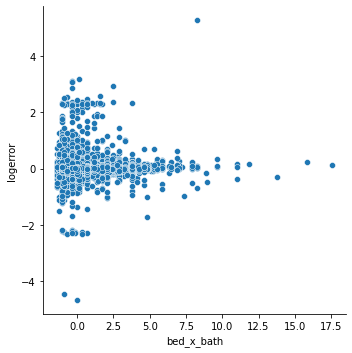

<Figure size 432x288 with 0 Axes>

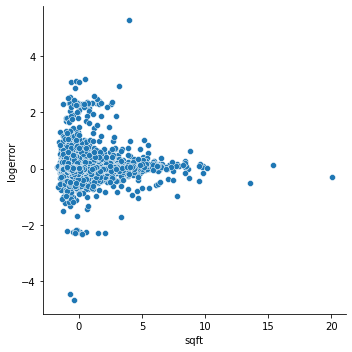

<Figure size 432x288 with 0 Axes>

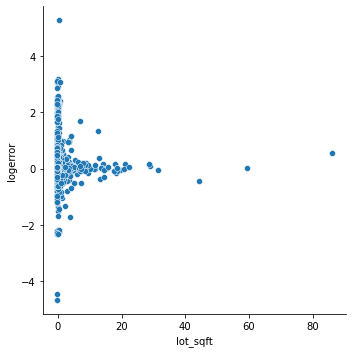

<Figure size 432x288 with 0 Axes>

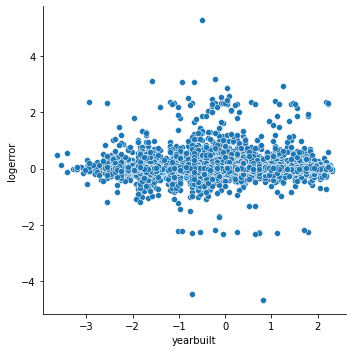

<Figure size 432x288 with 0 Axes>

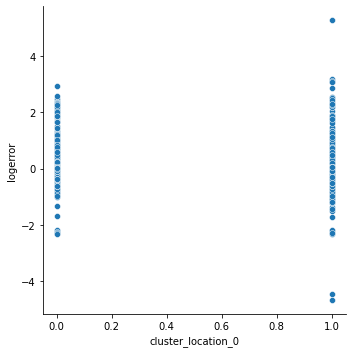

<Figure size 432x288 with 0 Axes>

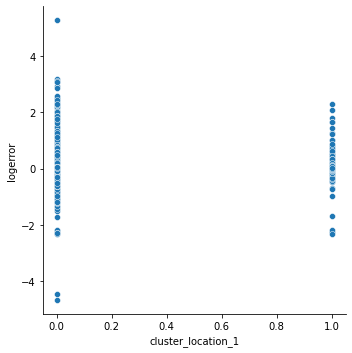

<Figure size 432x288 with 0 Axes>

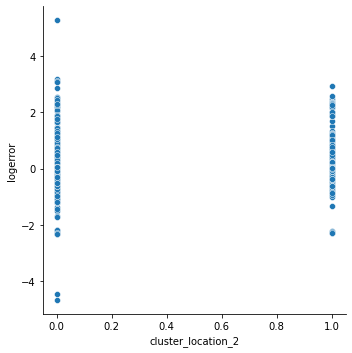

<Figure size 432x288 with 0 Axes>

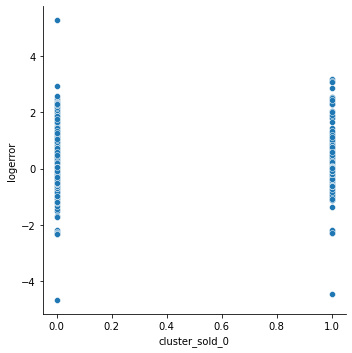

<Figure size 432x288 with 0 Axes>

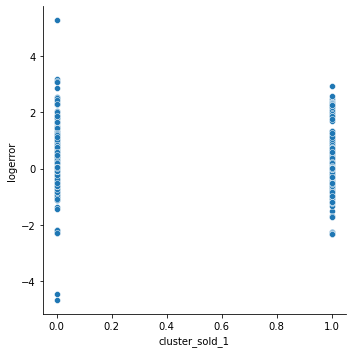

<Figure size 432x288 with 0 Axes>

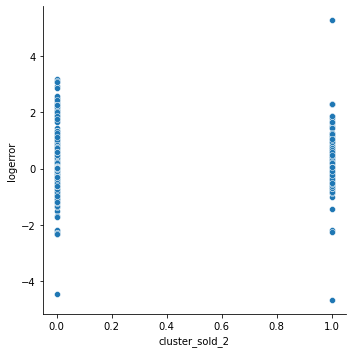

In [143]:
for col in x_trss_model.columns:
    plt.figure()
    sns.relplot(x = x_trss_model[col], y = y_train_ss)

In [144]:
# I am going to do a linear regression model (polynomial regression or lasso or tweedie) , clustering (Kmeans, DBSCAN), and a classification model (random forest tree) then decide where to go from there.



<Figure size 432x288 with 0 Axes>

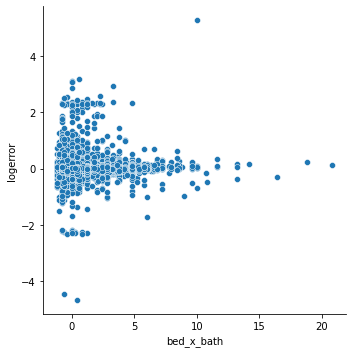

<Figure size 432x288 with 0 Axes>

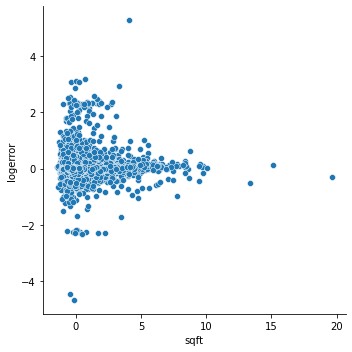

<Figure size 432x288 with 0 Axes>

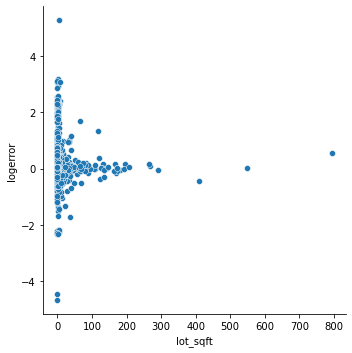

<Figure size 432x288 with 0 Axes>

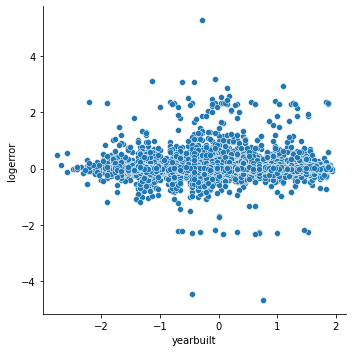

<Figure size 432x288 with 0 Axes>

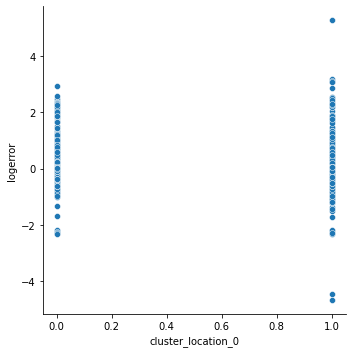

<Figure size 432x288 with 0 Axes>

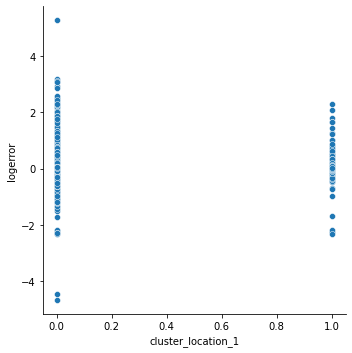

<Figure size 432x288 with 0 Axes>

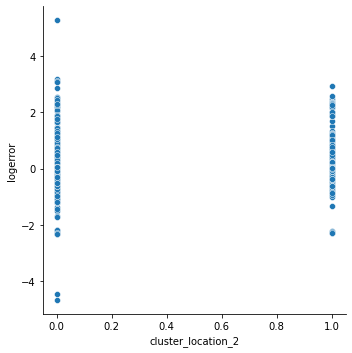

<Figure size 432x288 with 0 Axes>

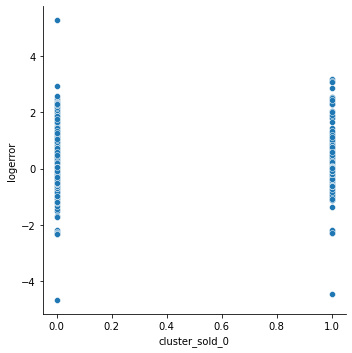

<Figure size 432x288 with 0 Axes>

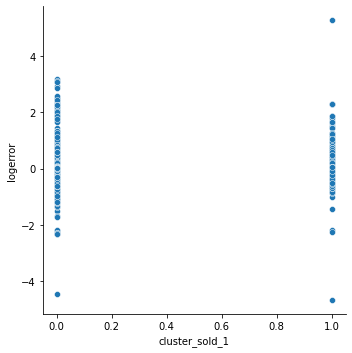

<Figure size 432x288 with 0 Axes>

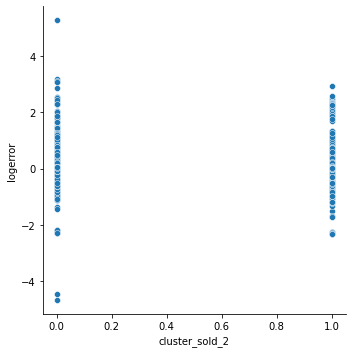

In [145]:
for col in x_trrs_model.columns:
    plt.figure()
    sns.relplot(x = x_trrs_model[col], y = y_train_rs)

# Baseline
because the target variable is both +/- numbers, i will be taking teh abs value to determine baseline mean and baseline realtionships

baseline is evaluated on RMSE of actual vs mean

# y_variable is not scaled, so ss and rs is the same

In [146]:
baseline = pd.DataFrame()

In [147]:
baseline['logerror'] = y_train_ss

In [148]:
baseline['abs_log'] = baseline.logerror.abs()

In [149]:
baseline['avg_abs_log'] = baseline.abs_log.mean()

In [150]:
baseline['difference'] = (baseline.abs_log - baseline.avg_abs_log)

In [151]:
baseline['abs_diff']= baseline.difference.abs()

In [152]:
baseline['sum_diff'] = baseline.abs_diff.sum()

In [153]:
baseline['avg_diff']= baseline.abs_diff.mean()

In [154]:
baseline

logerror   abs_log  avg_abs_log  difference  abs_diff     sum_diff  \
14166 -0.021764  0.021764     0.072328   -0.050564  0.050564  2028.905137   
34345  0.009199  0.009199     0.072328   -0.063129  0.063129  2028.905137   
51345  0.040741  0.040741     0.072328   -0.031587  0.031587  2028.905137   
5495   0.013744  0.013744     0.072328   -0.058584  0.058584  2028.905137   
35164  0.062963  0.062963     0.072328   -0.009366  0.009366  2028.905137   
...         ...       ...          ...         ...       ...          ...   
47111  0.027981  0.027981     0.072328   -0.044347  0.044347  2028.905137   
3377   0.068590  0.068590     0.072328   -0.003738  0.003738  2028.905137   
91    -0.064654  0.064654     0.072328   -0.007674  0.007674  2028.905137   
22416  0.013504  0.013504     0.072328   -0.058824  0.058824  2028.905137   
4638   0.050581  0.050581     0.072328   -0.021747  0.021747  2028.905137   

       avg_diff  
14166  0.069832  
34345  0.069832  
51345  0.069832  
5495   0.069832  
35164  0.069832  
...         ...  
47111  0.069832  
3377   0.069832  
91     0.069832  
22416  0.069832  
4638   0.069832  

[29054 rows x 7 columns]

In [155]:
rmse_baseline = mean_squared_error(baseline.logerror, baseline.avg_abs_log)**(1/2)
rmse_baseline

0.18857049392901554

In [156]:
rmse_baseline = mean_squared_error(baseline.abs_log, baseline.avg_abs_log)**(1/2)
rmse_baseline

0.16652630703887997

In [157]:
# Model 0 Random Forest Classifier

In [158]:
rf = RandomForestClassifier(max_depth = 10, random_state = 123)
#decision tree regressor type model, I don't know hwo to do regressor type so this is classification type only
#our target variable is continuous so we cannot use classification type model

# Number to beat is 
0.16652630703887997

In [159]:
rmse_summary = pd.DataFrame({'baseline': [rmse_baseline], 'lassolars': [0], 'poly_deg2':[0], 'glm':[0]})




In [160]:
rmse_summary

baseline  lassolars  poly_deg2  glm
0  0.166526          0          0    0

# Splitdata
I've already split train above. Now I need to do the same for validate and test

In [161]:
labels

prime_id targert_variable      size             time             location  \
0  parcelid         logerror      bath        yearbuilt                  zip   
1                                  bed  transactiondate                 fips   
2                                 sqft                              latitude   
3                             lot_sqft                             longitude   
4                                                               regionidcity   
5                                                             regionidcounty   
6                                                        censustractandblock   

                       other  
0  propertycountylandusecode  
1                             
2                             
3                             
4                             
5                             
6

In [162]:
x_trss_model = x_train_ss[['bed_x_bath', 'sqft', 'lot_sqft', 
                           'yearbuilt', 
                           'cluster_location', 'cluster_sold']]

In [163]:
x_trss_model = pd.get_dummies(x_trss_model, columns = ['cluster_location', 'cluster_sold'], dummy_na=False, drop_first= False)
x_trss_model.head()

bed_x_bath      sqft  lot_sqft  yearbuilt  cluster_location_0  \
14166   -0.035364 -0.195711 -0.174321   0.120493                   1   
34345   -1.070232 -0.889946 -0.140352  -0.579333                   1   
51345   -0.035364 -0.141615 -0.067528  -0.141942                   1   
5495    -0.380320 -0.481219 -0.156662   0.076753                   1   
35164   -0.380320 -0.230773 -0.090848   0.514145                   1   

       cluster_location_1  cluster_location_2  cluster_sold_0  cluster_sold_1  \
14166                   0                   0               0               0   
34345                   0                   0               1               0   
51345                   0                   0               0               1   
5495                    0                   0               0               0   
35164                   0                   0               1               0   

       cluster_sold_2  
14166               1  
34345               0  
51345               0  
5495                1  
35164               0

In [164]:
y_train_abs = y_train_ss.abs()
y_train_abs

14166    0.021764
34345    0.009199
51345    0.040741
5495     0.013744
35164    0.062963
           ...   
47111    0.027981
3377     0.068590
91       0.064654
22416    0.013504
4638     0.050581
Name: logerror, Length: 29054, dtype: float64

In [165]:
x_valss_model = x_validate_ss[['bed_x_bath', 'sqft', 'lot_sqft', 
                           'yearbuilt', 
                           'cluster_location', 'cluster_sold']]

In [166]:
x_valss_model = pd.get_dummies(x_valss_model, columns = ['cluster_location', 'cluster_sold'], dummy_na=False, drop_first= False)
x_valss_model.head()

bed_x_bath      sqft  lot_sqft  yearbuilt  cluster_location_0  \
39185    0.309593  0.576662 -0.002488   0.207971                   0   
29936   -0.380320 -0.374028  0.188418  -0.054464                   1   
15310   -0.725276 -0.172670 -0.146451  -1.016725                   1   
44731   -1.415189 -1.106331 -0.210783  -1.629073                   1   
32742   -0.380320 -0.791771 -0.007712  -0.491855                   1   

       cluster_location_1  cluster_location_2  cluster_sold_0  cluster_sold_1  \
39185                   0                   1               0               1   
29936                   0                   0               1               0   
15310                   0                   0               1               0   
44731                   0                   0               0               1   
32742                   0                   0               1               0   

       cluster_sold_2  
39185               0  
29936               0  
15310               0  
44731               0  
32742               0

In [167]:
y_val_abs = y_validate_ss.abs()
y_val_abs

39185    0.012378
29936    0.007490
15310    0.135031
44731    0.031856
32742    0.051655
           ...   
20957    0.039726
8569     0.011331
9685     0.071031
22350    0.041974
50716    0.018523
Name: logerror, Length: 12452, dtype: float64

In [168]:
x_testss_model = x_test_ss[['bed_x_bath', 'sqft', 'lot_sqft', 
                           'yearbuilt', 
                           'cluster_location', 'cluster_sold']]

In [169]:
x_testss_model = pd.get_dummies(x_testss_model, columns = ['cluster_location', 'cluster_sold'], dummy_na=False, drop_first= False)
x_testss_model.head()

bed_x_bath      sqft  lot_sqft  yearbuilt  cluster_location_0  \
47891   -0.380320 -0.593418  1.191273   0.907797                   1   
41917   -0.035364 -0.280863 -0.057789  -0.098203                   1   
14337   -0.897754 -0.843864 -0.144126  -0.448116                   1   
20487   -0.380320 -0.681575 -0.137016   0.382927                   0   
21309   -1.070232 -0.240791  0.029930  -1.891507                   1   

       cluster_location_1  cluster_location_2  cluster_sold_0  cluster_sold_1  \
47891                   0                   0               0               1   
41917                   0                   0               0               1   
14337                   0                   0               0               0   
20487                   0                   1               1               0   
21309                   0                   0               1               0   

       cluster_sold_2  
47891               0  
41917               0  
14337               1  
20487               0  
21309               0

In [170]:
y_test_abs = y_test_ss.abs()
y_test_abs

47891    0.009059
41917    0.006264
14337    0.010793
20487    0.070138
21309    0.002351
           ...   
8024     0.011167
48158    0.146386
13637    0.003502
13529    0.095361
384      0.047405
Name: logerror, Length: 10377, dtype: float64

# same for robust scaled data

In [171]:
x_trrs_model = x_train_rs[['bed_x_bath', 'sqft', 'lot_sqft', 
                           'yearbuilt', 
                           'cluster_location', 'cluster_sold']]

In [172]:
x_trrs_model = pd.get_dummies(x_trrs_model, columns = ['cluster_location', 'cluster_sold'], dummy_na=False, drop_first= False)
x_trrs_model.head()

bed_x_bath      sqft  lot_sqft  yearbuilt  cluster_location_0  \
14166         0.4  0.064922 -0.562859   0.206897                   1   
34345        -0.8 -0.606589 -0.249573  -0.344828                   1   
51345         0.4  0.117248  0.422067   0.000000                   1   
5495          0.0 -0.211240 -0.400000   0.172414                   1   
35164         0.0  0.031008  0.206993   0.517241                   1   

       cluster_location_1  cluster_location_2  cluster_sold_0  cluster_sold_1  \
14166                   0                   0               0               1   
34345                   0                   0               1               0   
51345                   0                   0               0               0   
5495                    0                   0               0               1   
35164                   0                   0               1               0   

       cluster_sold_2  
14166               0  
34345               0  
51345               1  
5495                0  
35164               0

In [173]:
x_valrs_model = x_validate_rs[['bed_x_bath', 'sqft', 'lot_sqft', 
                           'yearbuilt', 
                           'cluster_location', 'cluster_sold']]

In [174]:
x_valrs_model = pd.get_dummies(x_valrs_model, columns = ['cluster_location', 'cluster_sold'], dummy_na=False, drop_first= False)
x_valrs_model.head()

bed_x_bath      sqft  lot_sqft  yearbuilt  cluster_location_0  \
39185         0.8  0.812016  1.021911   0.275862                   0   
29936         0.0 -0.107558  2.782595   0.068966                   1   
15310        -0.4  0.087209 -0.305828  -0.689655                   1   
44731        -1.2 -0.815891 -0.899145  -1.172414                   1   
32742         0.0 -0.511628  0.973737  -0.275862                   1   

       cluster_location_1  cluster_location_2  cluster_sold_0  cluster_sold_1  \
39185                   0                   1               0               0   
29936                   0                   0               1               0   
15310                   0                   0               1               0   
44731                   0                   0               0               0   
32742                   0                   0               1               0   

       cluster_sold_2  
39185               1  
29936               0  
15310               0  
44731               1  
32742               0

In [175]:
x_testrs_model = x_test_rs[['bed_x_bath', 'sqft', 'lot_sqft', 
                           'yearbuilt', 
                           'cluster_location', 'cluster_sold']]

In [176]:
x_testrs_model = pd.get_dummies(x_testrs_model, columns = ['cluster_location', 'cluster_sold'], dummy_na=False, drop_first= False)
x_testrs_model.head()

bed_x_bath      sqft   lot_sqft  yearbuilt  cluster_location_0  \
47891         0.0 -0.319767  12.031702   0.827586                   1   
41917         0.4 -0.017442   0.511888   0.034483                   1   
14337        -0.6 -0.562016  -0.284382  -0.241379                   1   
20487         0.0 -0.405039  -0.218803   0.413793                   0   
21309        -0.8  0.021318   1.320901  -1.379310                   1   

       cluster_location_1  cluster_location_2  cluster_sold_0  cluster_sold_1  \
47891                   0                   0               0               0   
41917                   0                   0               0               0   
14337                   0                   0               0               1   
20487                   0                   1               1               0   
21309                   0                   0               1               0   

       cluster_sold_2  
47891               1  
41917               1  
14337               0  
20487               0  
21309               0

# Model 1 GLM
The data is not have an obvious trend. Gonig with the most flexible regression algorithm

Generalized Linear Model

The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the TweedieRegressor2 method to create a GLM using sklearn.

sklearn.linear_model.TweedieRegressor(power=0, alpha=1.0)

About power power = 0: Normal Distribution \
power = 1: Poisson Distribution \
power = (1,2): Compound Distribution \
power = 2: Gamma Distribution \
power = 3: Inverse Gaussian Distribution


In [177]:
# create the model object
glm0 = TweedieRegressor(power=0, alpha=0)

# fit the model ONLY to our training data.  

glm0.fit(x_trss_model, y_train_ss)

# predict train
y_tr_s_glm0 = glm0.predict(x_trss_model)

y_tr_s_glm0a = np.abs(y_tr_s_glm0)

# evaluate: rmse
rmse_train_glm0 = mean_squared_error(y_train_abs, y_tr_s_glm0a)**(1/2)

# predict validate
y_val_s_glm0 = glm0.predict(x_valss_model)

y_val_s_glm0a = np.abs(y_val_s_glm0)
# evaluate: rmse
rmse_validate_glm0 = mean_squared_error(y_val_abs, y_val_s_glm0a)**(1/2)

print("RMSE for OLS using GLM\nTraining/In-Sample: ", rmse_train_glm0, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm0)

RMSE for OLS using GLM
Training/In-Sample:  0.17504833643351592 
Validation/Out-of-Sample:  0.16460465704788355


In [178]:
rmse_summary['glm0_val_ss']= rmse_validate_glm0

In [179]:
rmse_summary['glm0_tr_ss']= rmse_train_glm0

In [180]:
rmse_summary.drop(columns = 'glm', inplace = True)


In [181]:
rmse_summary

baseline  lassolars  poly_deg2  glm0_val_ss  glm0_tr_ss
0  0.166526          0          0     0.164605    0.175048

In [182]:
# create the model object
glm0 = TweedieRegressor(power=0, alpha=0)

# fit the model ONLY to our training data.  

glm0.fit(x_trrs_model, y_train_ss)

# predict train
y_tr_rs_glm0 = glm0.predict(x_trrs_model)

y_tr_rs_glm0a = np.abs(y_tr_rs_glm0)

# evaluate: rmse
rmse_train_glm0 = mean_squared_error(y_train_abs, y_tr_rs_glm0a)**(1/2)

# predict validate
y_val_rs_glm0 = glm0.predict(x_valrs_model)

y_val_rs_glm0a = np.abs(y_val_rs_glm0)
# evaluate: rmse
rmse_validate_glm0 = mean_squared_error(y_val_abs, y_val_rs_glm0a)**(1/2)

print("RMSE for OLS using GLM\nTraining/In-Sample: ", rmse_train_glm0, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm0)

RMSE for OLS using GLM
Training/In-Sample:  0.17504403535086738 
Validation/Out-of-Sample:  0.1646005783710767


In [183]:
rmse_summary['glm0_val_rs']= rmse_validate_glm0

In [184]:
rmse_summary['glm0_tr_rs']= rmse_train_glm0

# #2 Polynomial Regression

In [185]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
x_tr_ss_deg1 = pf.fit_transform(x_trss_model)

# transform X_train and val_scaled
x_tr_ss_deg1 = pf.transform(x_trss_model)
x_val_ss_deg1 = pf.transform(x_valss_model)

In [186]:
# create the model object
lm1 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm1.fit(x_tr_ss_deg1, y_train_ss)

# predict train
y_trss_deg1 = lm1.predict(x_tr_ss_deg1)

y_trss_deg1a = np.abs(y_trss_deg1)
# evaluate: rmse
rmse_train = mean_squared_error(y_train_abs, y_trss_deg1a)**(1/2)

# predict validate
y_valss_deg1 = lm1.predict(x_val_ss_deg1)
y_valss_deg1a = np.abs(y_valss_deg1)
# evaluate: rmse
rmse_validate = mean_squared_error(y_val_abs, y_valss_deg1a)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.17465107101268681 
Validation/Out-of-Sample:  0.16446693989005232


In [187]:
rmse_summary['poly2_val_ss']= rmse_validate

In [188]:
rmse_summary['poly2_tr_ss']= rmse_train

In [189]:
rmse_summary.drop(columns = 'poly_deg2', inplace = True)

In [190]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
x_tr_rs_deg1 = pf.fit_transform(x_trrs_model)

# transform X_train and val_scaled
x_tr_rs_deg1 = pf.transform(x_trrs_model)
x_val_rs_deg1 = pf.transform(x_valrs_model)

In [191]:
# create the model object
lm1 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm1.fit(x_tr_rs_deg1, y_train_ss)

# predict train
y_trrs_deg1 = lm1.predict(x_tr_rs_deg1)

y_trrs_deg1a = np.abs(y_trrs_deg1)
# evaluate: rmse
rmse_train = mean_squared_error(y_train_abs, y_trrs_deg1a)**(1/2)

# predict validate
y_valrs_deg1 = lm1.predict(x_val_rs_deg1)
y_valrs_deg1a = np.abs(y_valrs_deg1)
# evaluate: rmse
rmse_validate = mean_squared_error(y_val_abs, y_valrs_deg1a)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.17459039487656378 
Validation/Out-of-Sample:  0.16443967996876188


In [192]:
rmse_summary['poly2_val_rs']= rmse_validate

In [193]:
rmse_summary['poly2_tr_rs']= rmse_train

# #3 Lasso Lars

In [194]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model ONLY to our training data.  

lars.fit(x_trss_model, y_train_ss)

# predict train
y_tr_s_lars = lars.predict(x_trss_model)

y_tr_s_larsa = np.abs(y_tr_s_lars)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_abs, y_tr_s_larsa)**(1/2)

# predict validate
y_val_s_lars = lars.predict(x_valss_model)
y_val_s_larsa = np.abs(y_val_s_lars)
# evaluate: rmse
rmse_validate = mean_squared_error(y_val_abs, y_val_s_larsa)**(1/2)

print("RMSE for OLS using Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using Lars
Training/In-Sample:  0.17509786373388636 
Validation/Out-of-Sample:  0.16456366714059723


In [195]:
rmse_summary['lassolars_val_ss']= rmse_validate

In [196]:
rmse_summary['lassolars_tr_ss']= rmse_train

In [197]:
rmse_summary.drop(columns = 'lassolars', inplace = True)

In [198]:
rmse_summary

baseline  glm0_val_ss  glm0_tr_ss  glm0_val_rs  glm0_tr_rs  poly2_val_ss  \
0  0.166526     0.164605    0.175048     0.164601    0.175044      0.164467   

   poly2_tr_ss  poly2_val_rs  poly2_tr_rs  lassolars_val_ss  lassolars_tr_ss  
0     0.174651       0.16444      0.17459          0.164564         0.175098

In [199]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model ONLY to our training data.  

lars.fit(x_trrs_model, y_train_ss)

# predict train
y_tr_rs_lars = lars.predict(x_trrs_model)

y_tr_rs_larsa = np.abs(y_tr_rs_lars)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_abs, y_tr_rs_larsa)**(1/2)

# predict validate
y_val_rs_lars = lars.predict(x_valrs_model)
y_val_rs_larsa = np.abs(y_val_rs_lars)
# evaluate: rmse
rmse_validate = mean_squared_error(y_val_abs, y_val_rs_larsa)**(1/2)

print("RMSE for OLS using Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using Lars
Training/In-Sample:  0.17509786373388636 
Validation/Out-of-Sample:  0.16456366714059723


In [200]:
rmse_summary['lassolars_val_rs']= rmse_validate

In [201]:
rmse_summary['lassolars_tr_rs']= rmse_train

# #4 Linear Regression

In [202]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model ONLY to our training data.  

lm.fit(x_trss_model, y_train_ss)

# predict train
y_trslm = lm.predict(x_trss_model)
y_trslma = np.abs(y_trslm)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_abs, y_trslma)**(1/2)

# predict validate
y_valslm = lm.predict(x_valss_model)
y_valslma = np.abs(y_valslm)
# evaluate: rmse
rmse_validate = mean_squared_error(y_val_abs, y_valslma)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  0.17505468843691216 
Validation/Out-of-Sample:  0.1646157363431801


In [203]:
rmse_summary['linreg_val_ss']= rmse_validate

In [204]:
rmse_summary['linreg_tr_ss']= rmse_train

In [205]:
rmse_summary

baseline  glm0_val_ss  glm0_tr_ss  glm0_val_rs  glm0_tr_rs  poly2_val_ss  \
0  0.166526     0.164605    0.175048     0.164601    0.175044      0.164467   

   poly2_tr_ss  poly2_val_rs  poly2_tr_rs  lassolars_val_ss  lassolars_tr_ss  \
0     0.174651       0.16444      0.17459          0.164564         0.175098   

   lassolars_val_rs  lassolars_tr_rs  linreg_val_ss  linreg_tr_ss  
0          0.164564         0.175098       0.164616      0.175055

In [206]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model ONLY to our training data.  

lm.fit(x_trrs_model, y_train_ss)

# predict train
y_trrslm = lm.predict(x_trrs_model)
y_trrslma = np.abs(y_trrslm)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_abs, y_trrslma)**(1/2)

# predict validate
y_valrslm = lm.predict(x_valrs_model)
y_valrslma = np.abs(y_valrslm)
# evaluate: rmse
rmse_validate = mean_squared_error(y_val_abs, y_valslma)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  0.17506339704563265 
Validation/Out-of-Sample:  0.1646157363431801


In [207]:
rmse_summary['linreg_val_rs']= rmse_validate

In [208]:
rmse_summary['linreg_tr_rs']= rmse_train

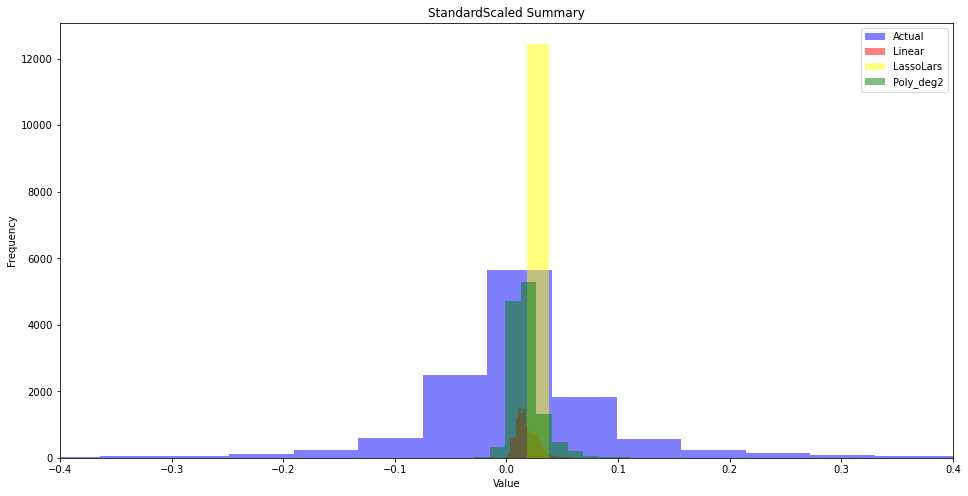

In [234]:
#Distribution of my models' predictions
plt.figure(figsize=(16,8))

plt.hist(y_validate_ss, bins = 100, color='blue', alpha=0.5, label='Actual')
plt.hist(y_valslm, bins = 50, color='red', alpha=0.5, label='Linear')
plt.hist(y_val_s_lars, bins = 50, color='yellow', alpha=0.5, label='LassoLars')
plt.hist(y_valss_deg1, bins = 50, color='green', alpha=0.5, label='Poly_deg2')

plt.xlim(-.4,.4)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('StandardScaled Summary')
plt.legend()

In [210]:
y_train_ss.shape, y_trslm.shape, y_tr_s_lars.shape, y_trss_deg1.shape

((29054,), (29054,), (29054,), (29054,))

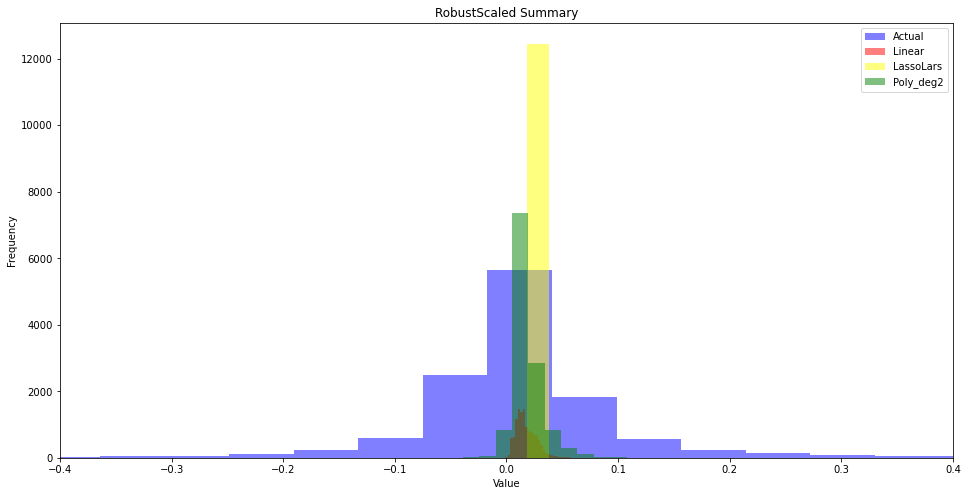

In [235]:
#Distribution of my models' predictions
plt.figure(figsize=(16,8))

plt.hist(y_validate_rs, bins = 100, color='blue', alpha=0.5, label='Actual')
plt.hist(y_valrslm, bins = 50, color='red', alpha=0.5, label='Linear')
plt.hist(y_val_rs_lars, bins = 50, color='yellow', alpha=0.5, label='LassoLars')
plt.hist(y_valrs_deg1, bins = 50, color='green', alpha=0.5, label='Poly_deg2')

plt.xlim(-.4,.4)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('RobustScaled Summary')
plt.legend()

In [212]:
rmse_sumT = rmse_summary.T

In [213]:
rmse_sumT.sort_values(by = 0)

0
poly2_val_rs      0.164440
poly2_val_ss      0.164467
lassolars_val_rs  0.164564
lassolars_val_ss  0.164564
glm0_val_rs       0.164601
glm0_val_ss       0.164605
linreg_val_ss     0.164616
linreg_val_rs     0.164616
baseline          0.166526
poly2_tr_rs       0.174590
poly2_tr_ss       0.174651
glm0_tr_rs        0.175044
glm0_tr_ss        0.175048
linreg_tr_ss      0.175055
linreg_tr_rs      0.175063
lassolars_tr_ss   0.175098
lassolars_tr_rs   0.175098

# Polynomial Deg 2 with Robust Scaling is the best 

In [214]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
x_tr_rs_deg1 = pf.fit_transform(x_trrs_model)

# transform X_train and val_scaled
x_tr_rs_deg1 = pf.transform(x_trrs_model)
x_test_rs_deg1 = pf.transform(x_testrs_model)

In [215]:
# create the model object
lm1 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm1.fit(x_tr_rs_deg1, y_train_ss)

# predict train
y_trrs_deg1 = lm1.predict(x_tr_rs_deg1)

y_trrs_deg1a = np.abs(y_trrs_deg1)
# evaluate: rmse
rmse_train = mean_squared_error(y_train_abs, y_trrs_deg1a)**(1/2)

# predict validate
y_testrs_deg1 = lm1.predict(x_test_rs_deg1)
y_testrs_deg1a = np.abs(y_testrs_deg1)
# evaluate: rmse
rmse_validate = mean_squared_error(y_test_abs, y_testrs_deg1a)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nTest/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.17459039487656378 
Test/Out-of-Sample:  0.1627365919346737


Baseline rmse: 0.166526 \
Test rmse: 0.162737

Improvement!!

In [216]:
((0.166526 - 0.162737)/0.166526)*100

2.2753203703926204

# 2.28% increase in accuracy!!

# Conclusion
- Polynomial Regression of the Second Order gave the best results
- Model gives a 2.28% increase in accuracy

# Future Work
- Continue analyzing independent variables to find a stronger correlation with dependent variable
- If I had more time I would run models with different hyperparameters to verify I had the best model available
- I would like to split the data based on land (0 bed/bath), home (1 bath, 1-5 bed), mansion (>5 bed) and run models specific to each

# Thank you!!
# Questions?